<a href="https://colab.research.google.com/github/ignacioPadilla/inteligenciaProyecto/blob/main/Experimentos_y_creacion_de_redes_para_proyeto_final_inteligencia_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import time

import torch
from torch import nn
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd

from torchvision.ops import box_iou as box_iou

# **Datasets a utilizar**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Localización de husos sigma en el EEG del sueño'

Mounted at /content/drive


In [ ]:
#TRAIN
#signals son las señales completas, cada señal se compone de 800 puntos(4463 señales).
dir_train_signals = path + "/train_signals.npy"
train_signals = torch.from_numpy(np.load(pathlib.Path(dir_train_signals))) #Tiene una señal muestreada con valores reales como Tensor



#marks son las respuestas, en cual punto comienza y termina el huso sigma.
dir_train_marks = path + "/train_marks.npy"
train_marks = np.load(pathlib.Path(dir_train_marks))  

#TEST
dir_test_signals = path + "/test_signals.npy"
test_signals = torch.from_numpy(np.load(pathlib.Path(dir_test_signals))) #Tiene una señal muestreada con valores reales como Tensor 

dir_test_marks = path + "/test_marks.npy"
test_marks = np.load(pathlib.Path(dir_test_marks))

#VALIDATION
dir_val_signals = path + "/val_signals.npy"
val_signals = torch.from_numpy(np.load(pathlib.Path(dir_val_signals))) #Tiene una señal muestreada con valores reales como Tensor

dir_val_marks = path + "/val_marks.npy"
val_marks = np.load(pathlib.Path(dir_val_marks))


## ***Exploración de datos***

## Datos tipo "signals"

In [ ]:
print("Las dimensiones de train signal son:")
print(train_signals.shape)
print("Lo que quiere decir que tenemos {} señales con {} muestras".format(train_signals.shape[0], train_signals.shape[1]))
print()
print("Las dimensiones de test signal son: ")
print(test_signals.shape)
print("Lo que quiere decir que  tenemos {} señales con {} muestras".format(test_signals.shape[0], test_signals.shape[1]))
print()
print("Las dimensiones de val signal son:")
print(val_signals.shape)
print("Lo que quiere decir que tenemos {} señales con {} muestras".format(val_signals.shape[0], val_signals.shape[1]))

Las dimensiones de train signal son:
torch.Size([4463, 800])
Lo que quiere decir que tenemos 4463 señales con 800 muestras

Las dimensiones de test signal son: 
torch.Size([2256, 800])
Lo que quiere decir que  tenemos 2256 señales con 800 muestras

Las dimensiones de val signal son:
torch.Size([1808, 800])
Lo que quiere decir que tenemos 1808 señales con 800 muestras


## Gráfico de una señal tipo signal

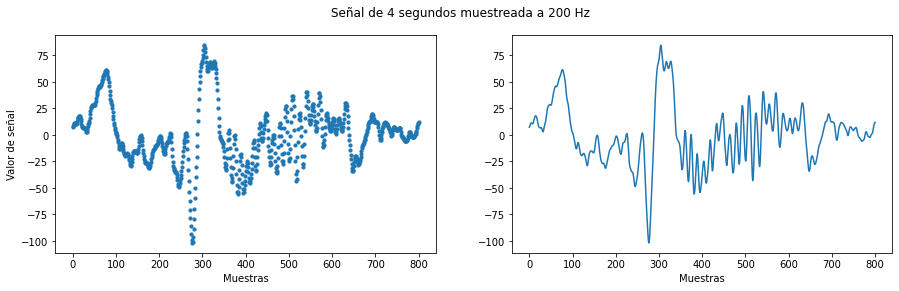

In [ ]:
muestras=np.linspace(0, 800, num=800)
# Crear la figura y los ejes
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].set_xlabel('Muestras')
ax[1].set_xlabel('Muestras')
ax[0].set_ylabel('Valor de señal')
plt.suptitle('Señal de 4 segundos muestreada a 200 Hz')
# Dibujar puntos
ax[0].scatter(muestras, train_signals[40], s=10)
ax[1].plot(muestras, train_signals[40])
# Mostrar el gráfico
plt.show()

El segmento anterior tiene una duración de 4 segundos y fue muestreado a una frecuencia de 200Hz, es por ello que se tienen 800 muestras

## Datos tipo marks

In [ ]:
print("Las dimensiones de train marks son:")
print(train_marks.shape)
print("Lo que quiere decir que tenemos {} señales con su inicio y fin del huso del sueño".format(train_marks.shape[0]))
print()
print("Las dimensiones de test marks son: ")
print(test_marks.shape)
print("Lo que quiere decir que tenemos {} señales con su inicio y fin del huso del sueño".format(test_marks.shape[0]))
print()
print("Las dimensiones de val marks son:")
print(val_marks.shape)
print("Lo que quiere decir que tenemos {} señales con su inicio y fin del huso del sueño".format(val_marks.shape[0]))

Las dimensiones de train marks son:
(4463, 2)
Lo que quiere decir que tenemos 4463 señales con su inicio y fin del huso del sueño

Las dimensiones de test marks son: 
(2256, 2)
Lo que quiere decir que tenemos 2256 señales con su inicio y fin del huso del sueño

Las dimensiones de val marks son:
(1808, 2)
Lo que quiere decir que tenemos 1808 señales con su inicio y fin del huso del sueño


A continuación con los datos de marks podemos obtener las CLASES para la señal tipo signal, ya que se sabe en que posicion empieza y termina el huso, es por ello que se define la función "crea_y" para poder obtener las clases

In [ ]:
def crea_y(mark):
  muestras,dim = mark.shape
  salida=np.zeros(800)
  for i in range(muestras):
    vector = np.zeros(800)
    inicio = mark[i][0]
    final = mark[i][1]
    while inicio <= final:
      vector[inicio] = 1
      inicio = inicio+1
    salida = np.vstack([salida,vector])
  salida = np.delete(salida, 0, axis=0)
  return salida

In [ ]:
y_train = crea_y(train_marks)
y_test = crea_y(test_marks)
y_val = crea_y(val_marks)

# **Normalización de datos**

In [ ]:
for i in range(4463):
  train_signals[i]=(train_signals[i]-train_signals[i].mean())/(train_signals[i].std())

In [ ]:
for i in range(len(val_signals)):
  val_signals[i]=(val_signals[i]-val_signals[i].mean())/(val_signals[i].std())

In [ ]:
df = pd.DataFrame(train_signals)
df

0                1                2                3    \
0      tensor(0.7428)   tensor(0.7461)   tensor(0.6061)   tensor(0.4303)   
1      tensor(1.0760)   tensor(1.0258)   tensor(1.0235)   tensor(1.0538)   
2      tensor(0.1877)   tensor(0.2531)   tensor(0.2384)   tensor(0.1249)   
3     tensor(-0.4053)  tensor(-0.4833)  tensor(-0.5195)  tensor(-0.5067)   
4     tensor(-0.0737)  tensor(-0.0625)  tensor(-0.0843)  tensor(-0.1897)   
...               ...              ...              ...              ...   
4458   tensor(1.4074)   tensor(1.3380)   tensor(1.2578)   tensor(1.1472)   
4459  tensor(-0.2214)  tensor(-0.1705)  tensor(-0.1251)  tensor(-0.0859)   
4460  tensor(-0.0683)  tensor(-0.0268)  tensor(-0.0185)  tensor(-0.0111)   
4461  tensor(-1.5053)  tensor(-1.4350)  tensor(-1.3512)  tensor(-1.2768)   
4462  tensor(-0.3274)  tensor(-0.4257)  tensor(-0.5502)  tensor(-0.6945)   

                  4                5                6                7    \
0      tensor(0.2952)   tensor(0.2138)   tensor(0.1639)   tensor(0.1246)   
1      tensor(1.0835)   tensor(1.0935)   tensor(1.0837)   tensor(1.0694)   
2     tensor(-0.0896)  tensor(-0.4020)  tensor(-0.7997)  tensor(-1.2447)   
3     tensor(-0.4458)  tensor(-0.3487)  tensor(-0.2269)  tensor(-0.0779)   
4     tensor(-0.3629)  tensor(-0.5273)  tensor(-0.6055)  tensor(-0.5850)   
...               ...              ...              ...              ...   
4458   tensor(0.9625)   tensor(0.7179)   tensor(0.5083)   tensor(0.4279)   
4459  tensor(-0.0459)   tensor(0.0034)   tensor(0.0648)   tensor(0.1409)   
4460   tensor(0.0305)   tensor(0.1138)   tensor(0.2291)   tensor(0.3653)   
4461  tensor(-1.2096)  tensor(-1.1428)  tensor(-1.0890)  tensor(-1.0652)   
4462  tensor(-0.8334)  tensor(-0.9382)  tensor(-0.9956)  tensor(-1.0153)   

                  8                9    ...              790              791  \
0      tensor(0.0867)   tensor(0.0471)  ...   tensor(1.2493)   tensor(1.2275)   
1      tensor(1.0753)   tensor(1.1094)  ...  tensor(-1.2655)  tensor(-1.3320)   
2     tensor(-1.6672)  tensor(-1.9844)  ...  tensor(-0.1260)  tensor(-0.0883)   
3      tensor(0.1114)   tensor(0.3389)  ...  tensor(-0.3089)  tensor(-0.0628)   
4     tensor(-0.5224)  tensor(-0.4865)  ...   tensor(0.1431)  tensor(-0.0398)   
...               ...              ...  ...              ...              ...   
4458   tensor(0.4821)   tensor(0.6000)  ...  tensor(-0.9940)  tensor(-1.0958)   
4459   tensor(0.2410)   tensor(0.3733)  ...  tensor(-1.5493)  tensor(-1.5306)   
4460   tensor(0.4947)   tensor(0.5631)  ...  tensor(-0.7769)  tensor(-0.8169)   
4461  tensor(-1.0671)  tensor(-1.0647)  ...  tensor(-1.4920)  tensor(-1.3409)   
4462  tensor(-1.0182)  tensor(-1.0197)  ...   tensor(0.3830)   tensor(0.3596)   

                  792              793              794              795  \
0      tensor(1.1692)   tensor(1.0814)   tensor(0.9775)   tensor(0.8874)   
1     tensor(-1.4255)  tensor(-1.5317)  tensor(-1.5899)  tensor(-1.5463)   
2     tensor(-0.0751)  tensor(-0.0651)  tensor(-0.0290)   tensor(0.0518)   
3      tensor(0.1755)   tensor(0.4007)   tensor(0.6320)   tensor(0.8732)   
4     tensor(-0.1867)  tensor(-0.2927)  tensor(-0.3845)  tensor(-0.4846)   
...               ...              ...              ...              ...   
4458  tensor(-1.1354)  tensor(-1.1465)  tensor(-1.1423)  tensor(-1.1167)   
4459  tensor(-1.5838)  tensor(-1.6707)  tensor(-1.7327)  tensor(-1.7264)   
4460  tensor(-0.8445)  tensor(-0.8457)  tensor(-0.7997)  tensor(-0.6942)   
4461  tensor(-1.1199)  tensor(-0.8936)  tensor(-0.7192)  tensor(-0.6355)   
4462   tensor(0.3424)   tensor(0.3316)   tensor(0.3204)   tensor(0.2980)   

                  796              797              798              799  
0      tensor(0.8495)   tensor(0.8811)   tensor(0.9567)   tensor(1.0079)  
1     tensor(-1.3861)  tensor(-1.1075)  tensor(-0.7013)  tensor(-0.1796)  
2      tensor(0.1845)   tensor(0.3621)   tensor(0.5579)   tensor(0.7389)  
3     

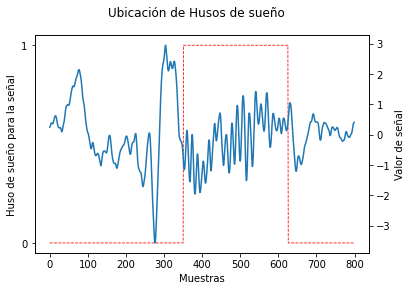

In [ ]:
### sanity check
index = 40

fig, ax = plt.subplots()
ax.plot(y_train[index,:], linestyle='dashed', linewidth=0.8, c='red')
ax.set_xlabel('Muestras')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(train_signals[index,:])
ax2.set_ylabel('Valor de señal')
plt.show()

## Gráfico de husos del sueño para una señal


*   0=No hay huso de sueño
*   1=Hay huso de sueño







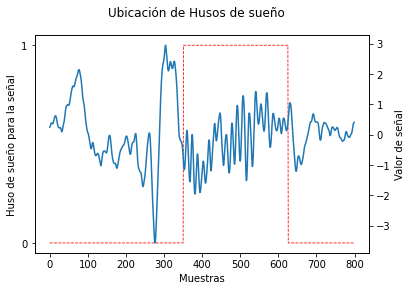

In [ ]:
### sanity check
index = 40

fig, ax = plt.subplots()
ax.plot(y_train[index,:], linestyle='dashed', linewidth=0.8, c='red')
ax.set_xlabel('Muestras')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(train_signals[index,:])
ax2.set_ylabel('Valor de señal')
plt.show()

# **Implementación de red neuronal**

In [ ]:
#De numpy a tensor
y_train = torch.tensor(y_train, dtype=torch.float64)
y_val = torch.tensor(y_val, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)


In [ ]:
#Se cambian dimensiones a las señales tipo signals para que tengan un canal y poder ocupar red convolucional
X_train = torch.reshape(train_signals, (len(train_signals), 1, 800)) ###,(4463,1,800)) 
X_val = torch.reshape(val_signals,(len(val_signals),1,800))              
X_test = torch.reshape(test_signals,(len(test_signals),1,800))

In [ ]:
print("Dimensiones de y_train:")
y_train.shape

Dimensiones de y_train:


torch.Size([4463, 800])

In [ ]:
print("Dimensiones de X_train:")
print(X_train.shape)
print("Tenemos 4463 datos de imagenes de 1x800 ")
print()
print("Dimensiones de X_val:")
print(X_val.shape)
print("Tenemos 1808 datos de imagenes de 1x800 ")
print()
print("Dimensiones de X_test:")
print(X_test.shape)
print("Tenemos 2256 datos de imagenes de 1x800 ")

Dimensiones de X_train:
torch.Size([4463, 1, 800])
Tenemos 4463 datos de imagenes de 1x800 

Dimensiones de X_val:
torch.Size([1808, 1, 800])
Tenemos 1808 datos de imagenes de 1x800 

Dimensiones de X_test:
torch.Size([2256, 1, 800])
Tenemos 2256 datos de imagenes de 1x800 


In [ ]:
#DATASETS
train_dataset = torch.utils.data.TensorDataset(X_train, y_train) 
val_dataset = torch.utils.data.TensorDataset(X_val,y_val)
test_dataset =torch.utils.data.TensorDataset(X_test,y_test)

A continuación se prueba si los dataset cumplen la función de guardas las clases para las señales

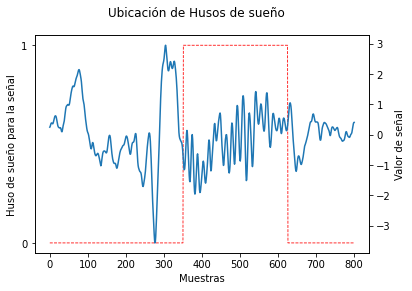

In [ ]:
index = 40

example_image, example_class = train_dataset[index]
muestras=np.linspace(0, 800, num=800)
# Crear la figura y los ejes


fig, ax = plt.subplots()
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze())
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

Cambio en las dimensiones al aplicar red convolucional a los datos

In [ ]:
example_image, example_class = train_dataset[40]
conv_layer = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=1)
output_image= conv_layer(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Input image shape: torch.Size([1, 800])
Output image shape: torch.Size([10, 800])


 ***RED NEURONAL ***

In [ ]:
class CNNModel(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 16, kernel_size=1), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(16, 32, kernel_size=1),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(32, 1, kernel_size=1),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
from torchsummary import summary

model = CNNModel(dropout_p=0.2)
### ESTA FUNCION SIRVE PARA MOSTRARLES CÓMO ES SU MODELO Y COMO SE VAN MODIFICANDO LAS DIMENSIONES DE SU INPUT

summary(model, (1,800))   ### EL SEGUNDO PARAMETRO ES LA DIMENSION DEL INPUT DE ENTRADA
### LES SIRVE PARA VISUALIZAR Y ENTENDER QUÉ HACE SU MODELO
### LA DIMENSION -1 INDICA LA DIMENSIÓN DEL BATCH (Q ES VARIABLE, UDS LA ELIGEN)

RuntimeError: ignored

In [ ]:
input=torch.from_numpy(np.array([70000,1,2,0.4,-1]))
m = nn.ReLU()
#input = torch.randn(2)
output = m(input)
print(output)
n=nn.Sigmoid()
output1=n(input)
print(output1)


tensor([7.0000e+04, 1.0000e+00, 2.0000e+00, 4.0000e-01, 0.0000e+00],
       dtype=torch.float64)
tensor([1.0000, 0.7311, 0.8808, 0.5987, 0.2689], dtype=torch.float64)


In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 3, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    ax[2].plot(epochs, curves['iou'], label='IoU')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('IoU')
    ax[2].set_title('IoU evolution during training')
    ax[2].legend()

    plt.show()

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    #Modelo entrenado con x_batch señales, el cual debería entregar una predicción de 800 números 
    #y a esa predicción hecha por el modela la llamamos "y_predicted"
    y_predicted = model(x_batch) #modelo entrega arreglo de 800 números con valores del 0 al 1
    #Loss es el criteio a utilizar para calcular la diferencia entre el "y_predicted"  y el "y_batch", para saber cuanto nos estamos equivocando
    loss = criterion(y_predicted, y_batch.float()) 

    # Actualización de parámetros
    optimizer.zero_grad() 
    loss.backward() #el error debido a loss se propaga hacia atras
    optimizer.step()
    return y_predicted, loss #train_step entrena la red con señales de tamaño x_batch, luego calcula el loss para finalmente propagar el error hacia atras


###PARA VALIDACION####
def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0 #Los que iremos acumulando a medida que recorremos las señales y hacemos una predicción
    cumulative_predictions = 0
    union = 0
    intersection=0
    ### Y SI SE CAMBIA EL SET DE VALIDACION? ESTO ESTÁ MAL
    ###data_count = 1808*800   #0
    data_count1=0
    for x_val, y_val in val_loader:  #toma una señal de x_val y su Clase de y_val y lo hace para todo el dataset val_loader
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val) #Hace una predicción para x_val con el modelo de redes neuronales. 

        loss = criterion(y_predicted, y_val.float()) #Se calcula un loss para ver en cuanto difiere la predicción de la red con el valor real que deberia dar

        class_prediction = (y_predicted >= 0.5).long() #Esto trasnforma a 0 o 1 el arreglo de 800 elementos que tenemos

        cumulative_predictions += (y_val == class_prediction).sum().item() #SUMA CASOS CORRECTAMENTE PREDICHOS
        cumulative_loss += loss.item() #EN EL LOSS SE CALCULA UN PROMEDIO DE CADA BATCH; POR ENDE SOLO SE NECESITA AL FINAL DIVIDIR POR N_BATCHs
        data_count1 += y_val.shape[0]*800   #EN EL ACC SE CALCULA POR CADA PUNTO DE CADA SEÑAL
        #CAMBIOS DESDE ACÁ 
        union += (class_prediction +  y_val - class_prediction*y_val).sum()
        intersection += (class_prediction * y_val).sum()
        iou = ((intersection)/(union+1e-8)).item()
  
    
    val_acc = cumulative_predictions/data_count1 ###/ data_count
    val_loss = cumulative_loss / len(val_loader) ###data_count1 ################

    return val_acc, val_loss, iou


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    ###n_evaluations_per_epoch=6,  ### ESTO NO ES NECESARIO, EL NUM DE EVALUACIONES POR EPOCA SUELE ESTAR DADO POR EL N_BATCHES, A MENOS Q SU 
    ### ENTRENAMIENTO SEA MUY LENTO
    use_gpu=False,
    data_augmentation=False,
):



    if use_gpu:
        model.cuda()

    # Definición de dataloader

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)

    ### ESTAN TRABAJANDO CON IMAGENES Y ESO USA MUCHA MEMORIA, PROBABLEMENTE NO LES VAN A ACEPTAR UN BATCH SIZE TAN GRANDE
    val_loader = torch.utils.data.DataLoader(val_dataset, #batch_size=len(val_dataset), 
                                             batch_size=batch_size, shuffle=False, pin_memory=use_gpu) #batch size es de tamaño 1808

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
        "iou": [],
    }

    t0 = time.perf_counter()

    ###iteration = 0

    n_batches = len(train_loader) #deberia ser 4463 

    for epoch in range(epochs): #si epochs es 4, entonces toma valores del 0 al 3
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0
###########################
        # Entrenamiento del modelo
        model.train()
        iteration = 0
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu) #Entrega el y predicted y el loss para una epoca

            cumulative_train_loss += loss.item() #Se acumula loss a medida que pasamos por los x_batch
            train_loss_count += 1   #800   ### LA FUNCION DE LOSS YA CALCULA UN PROMEDIO, POR ESO SE SUMA 1 Y NO 800
            ###train_acc_count =4463*800   #Antes tenia y_batch.shape[0] #Puse eso pq es el total de casos de 0 y 1 de todo el dataset
            ### ESE ES EL VALOR FINAL, SI VAN REPORTANDO SUS RESULTADOS A LO LARGO DEL ENTRENAMIENTO DENTRO DE CADA EPOCA ESTO ESTÁ MAL
            ### DEBEN IR SUMANDO CADA BATCH A MEDIDA QUE SE VA RECORRIENDO EL TRAIN SET
            ### (OJO, ADEMAS, QUE EL VALOR DEL BATCH NO SIEMPRE ES EL MISMO; PORQUE SI EL LARGO DEL DATASET NO ES MULTIPLO DEL BATCH_SIZE ENTONCES
            ### EL ULTIMO BATCH VA A SER MÁS CHICO QUE LOS DEMÁS
            train_acc_count += y_batch.shape[0]*800


            # Calculamos número de aciertos
            class_prediction = (y_predicted >= 0.5).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i%5 == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss, iou = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}, IoU: {iou}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        curves["iou"].append(iou)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()



    return curves, model   #### PARA RECUPERAR EL MODELO QUE ENTRENARON, EN ESTE CASO SE RETORNA EL MODELO CON LOS PESOS ACTUALIZADOS POR ULTIMA VEZ.
    #### LO OTRO QUE SE SUELE HACER ES EN CADA EPOCA COMPARAR LOS ACCURACY DE VALIDACION POR SI OCURRE OVERFIT Y GUARDAR LOS PESOS DEL MODELO CON MAYOR
    #### ACCURACY DE VALIDACION COMO "BEST_MODEL" Y DESPUES RETORNAR ESO (ES COMO SIMILAR A USAR EARLY STOPPING)

Epoch 1/15
Iteration 5 - Batch 5/140 - Train loss: 0.6834686001141866, Train acc: 0.6001822916666667
Iteration 10 - Batch 10/140 - Train loss: 0.6595626419240778, Train acc: 0.6672336647727273
Iteration 15 - Batch 15/140 - Train loss: 0.6209874469786882, Train acc: 0.70095458984375
Iteration 20 - Batch 20/140 - Train loss: 0.578522801399231, Train acc: 0.7197991071428571
Iteration 25 - Batch 25/140 - Train loss: 0.545583032644712, Train acc: 0.73236328125
Iteration 30 - Batch 30/140 - Train loss: 0.520250367541467, Train acc: 0.7403326612903226
Iteration 35 - Batch 35/140 - Train loss: 0.5030161357588239, Train acc: 0.7440060763888889
Iteration 40 - Batch 40/140 - Train loss: 0.4890990031928551, Train acc: 0.7473027820121951
Iteration 45 - Batch 45/140 - Train loss: 0.47784091920956323, Train acc: 0.7508092730978261
Iteration 50 - Batch 50/140 - Train loss: 0.4688679014935213, Train acc: 0.7536626838235294
Iteration 55 - Batch 55/140 - Train loss: 0.4608265997043678, Train acc: 0.75649

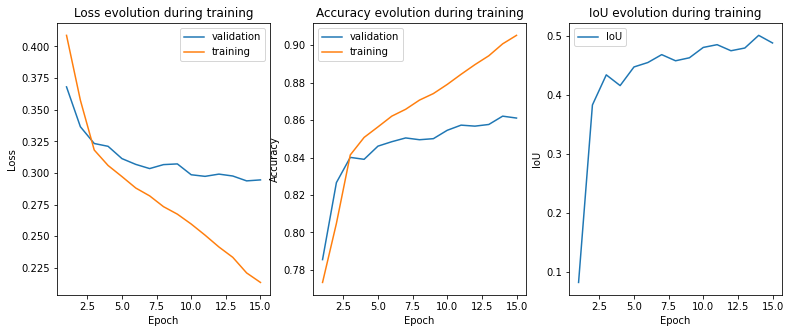

In [ ]:
lr = 5e-4
dropout_p = 0.5
batch_size = 32
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel(dropout_p=0.1)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)

In [ ]:
print(curves["val_loss"])
print(curves["iou"])

[0.36946352427465873, 0.3688291149181232, 0.36493655725529317, 0.3627227131734815, 0.35083706493963274, 0.33847514004038093, 0.3244043055333589, 0.28818274067159283, 0.2545866134919618, 0.2344847345038464, 0.22136772959901577, 0.21616070364650927, 0.20904166159922616, 0.20673050639922158, 0.2090418751825366]
[tensor(0.1814, device='cuda:0', dtype=torch.float64), tensor(0.1801, device='cuda:0', dtype=torch.float64), tensor(0.2257, device='cuda:0', dtype=torch.float64), tensor(0.1938, device='cuda:0', dtype=torch.float64), tensor(0.2754, device='cuda:0', dtype=torch.float64), tensor(0.3571, device='cuda:0', dtype=torch.float64), tensor(0.4106, device='cuda:0', dtype=torch.float64), tensor(0.4943, device='cuda:0', dtype=torch.float64), tensor(0.5512, device='cuda:0', dtype=torch.float64), tensor(0.5934, device='cuda:0', dtype=torch.float64), tensor(0.6182, device='cuda:0', dtype=torch.float64), tensor(0.6358, device='cuda:0', dtype=torch.float64), tensor(0.6439, device='cuda:0', dtype=tor

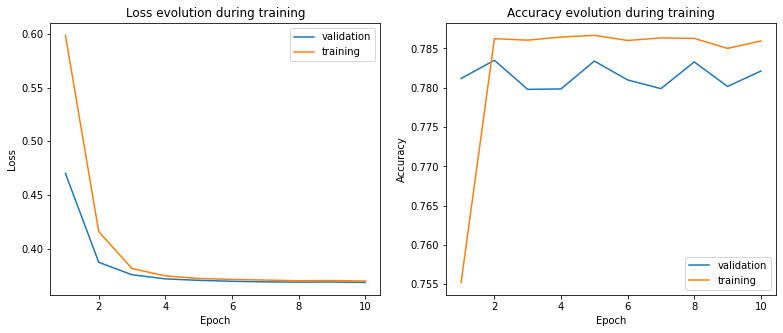

In [ ]:
show_curves(curves)

# **Aplicacion del umbral para transformar salida de la predicción en 0 y 1**

In [ ]:
#la salida de la red es un arreglo de 1 fila y 800 columnas, por eso en el codigo se agrega el x[0]
#para indicar que se está trabajando sobre la primera fila y recorriendo las columnas
def umbral(x):
  x_pred = np.zeros(x.shape)    ### PREFIERO HACER UN ARREGLO EXTRA PARA GUARDAR LA PREDICCION PORQUE DE OTRA MANERA A VECES EXISTE RIESGO
  ### DE QUE SE MODIFIQUE EL ARREGLO ORIGINAL Y ESO PUEDE TRAER PROBLEMAS.  NO ESO SI ESO OCURRE EXACTAMENTE EN ESTE CASO PERO YO PREFIERO
  ### TOMAR LOS RESGUARDOS jaja.
  for i in range(len(x[0])): 
    if x[0][i]>0.4:
      x_pred[0][i]=1
    #else:
    #  x[0][i]=0         ### EL ARREGLO x_pred YA ESTÁ INICIALIZADO EN 0s
  return x_pred


index = 50

example_image, example_class = test_dataset[index]
#a=umbral(example_image)                                ### ESTABAN APLICANDO ESTO EN LA SEÑAL DIRECTAMENTE, NO LA ESTABAN PASANDO POR EL MODELO!!
#a


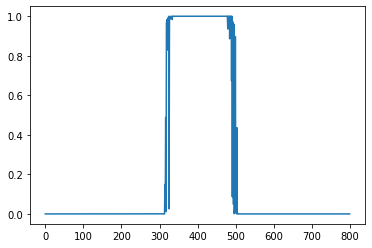

In [ ]:
### COMPROBEMOS QUE LA SALIDA DE LA RED SON PROBABILIDADES (ES DECIR ENTRE 0 y 1)
plt.plot(final_model(example_image).detach().numpy().squeeze())
plt.show()

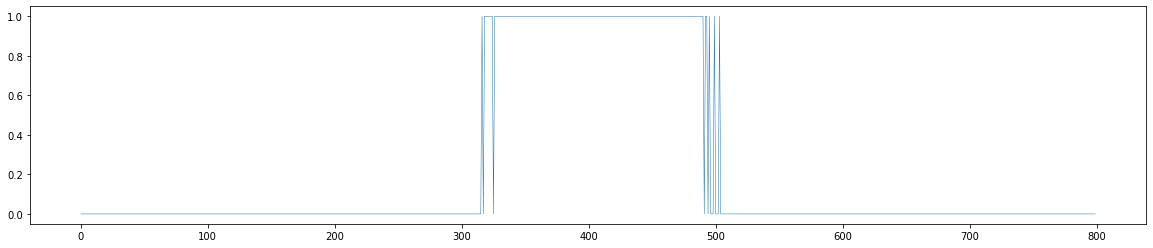

In [ ]:
### AHORA SI
a = umbral(final_model(example_image))
plt.figure(figsize=(20,4))
plt.plot(a[0], linewidth=0.5)
plt.show()

**Predicción hecha por la red**

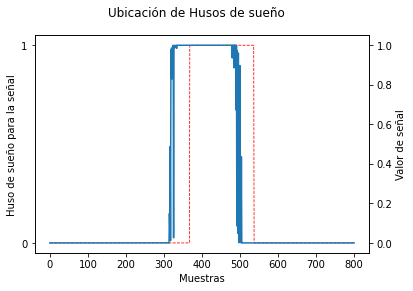

In [ ]:

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()

# Crear la figura y los ejes


fig, ax = plt.subplots()
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze())
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

**Predicción hecha por la red transformando valores a 0 y 1**

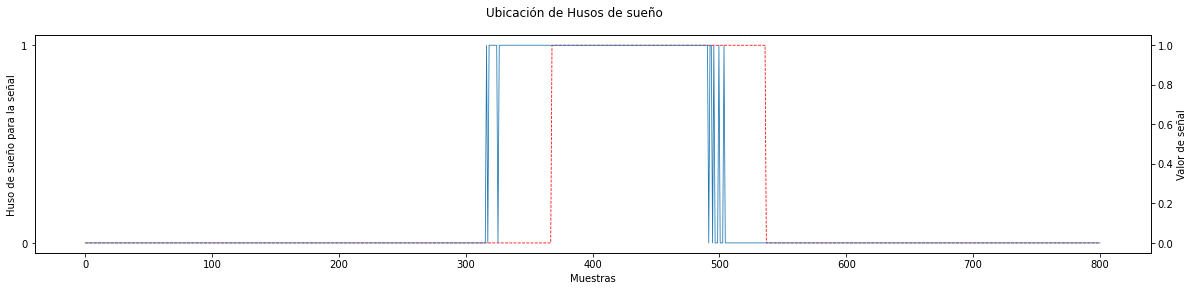

In [ ]:
#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(20,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

# **MEJORANDO LA RED**

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 15, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(15, 10,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(10, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6220776736736298, Train acc: 0.6424861111111111
Iteration 10 - Batch 10/298 - Train loss: 0.5452725507996299, Train acc: 0.6994393939393939
Iteration 15 - Batch 15/298 - Train loss: 0.498031472787261, Train acc: 0.7259010416666667
Iteration 20 - Batch 20/298 - Train loss: 0.4751626664683932, Train acc: 0.7395198412698413
Iteration 25 - Batch 25/298 - Train loss: 0.4550812462201485, Train acc: 0.7506378205128205
Iteration 30 - Batch 30/298 - Train loss: 0.44180444267488295, Train acc: 0.7592795698924731
Iteration 35 - Batch 35/298 - Train loss: 0.42831674218177795, Train acc: 0.7679652777777778
Iteration 40 - Batch 40/298 - Train loss: 0.41153021084099284, Train acc: 0.7790813008130081
Iteration 45 - Batch 45/298 - Train loss: 0.3968138166743776, Train acc: 0.7893967391304347
Iteration 50 - Batch 50/298 - Train loss: 0.38119102137930255, Train acc: 0.8004575163398693
Iteration 55 - Batch 55/298 - Train loss: 0.36505166201719214, Train

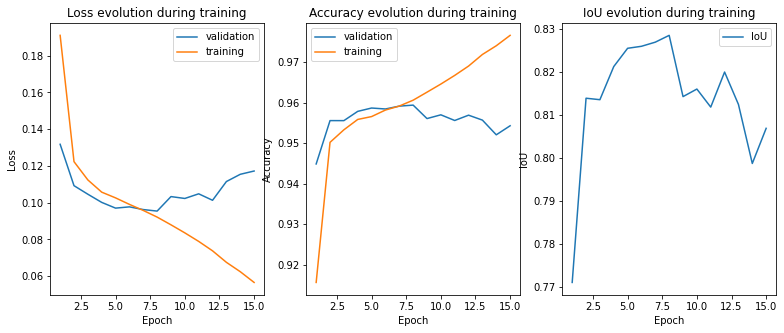

In [ ]:
lr = 0.001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.1)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)

In [ ]:
##Bloque para aplicar IoU final.

#función para el umbral, pasar a 0s y 1s.
def umbral(x):
  x_pred = np.zeros(x.shape)    ### PREFIERO HACER UN ARREGLO EXTRA PARA GUARDAR LA PREDICCION PORQUE DE OTRA MANERA A VECES EXISTE RIESGO
  ### DE QUE SE MODIFIQUE EL ARREGLO ORIGINAL Y ESO PUEDE TRAER PROBLEMAS.  NO ESO SI ESO OCURRE EXACTAMENTE EN ESTE CASO PERO YO PREFIERO
  ### TOMAR LOS RESGUARDOS jaja.
  for i in range(len(x[0])): 
    if x[0][i]>0.4:
      x_pred[0][i]=1

  return x_pred


#función para hacer continuo el resultado.
def linealizar_resultado(example_image2):
  example_image = example_image2.squeeze()

  inicio = 0

  for i in range(len(example_image)):
    if example_image[i] == 1:
      inicio = i
      break 
    

  for j in reversed(range(len(example_image))):
    if example_image[j] == 1:
      final = j
      break

  x_lin = np.zeros(example_image.shape[0])
  for h in range(len(x_lin)):
    if h >= inicio and h<= final:
      x_lin[h]=1
  return x_lin

#obtiene punto inicial y final de la señal.
def obt_puntos(x_lin,marks):
  for i in range(800):
    if x_lin[i]==1:
      inicio_pred = i
      break
  for j in range(800):
    if marks[j]==1:
      inicio_marks = j
      break
  for o in reversed(range(800)):
    if x_lin[o]==1:
      final_pred = o
      break
  for p in reversed(range(800)):
    if marks[p]==1:
      final_marks = p
      break
  return (inicio_pred,final_pred,inicio_marks,final_marks)


def iou(prediction,mark):
  #Tomo el comienzo y el final de la prediccion y los label
  x1_p=prediction[0]
  x2_p=prediction[1]
  x1_m=mark[0]
  x2_m=mark[1]

  #para la unión
  x1_u = min(x1_p,x1_m)
  x2_u = max(x2_p,x2_m)
  u_long = x2_u - x1_u + 1

  #para la intersección
  x1_i = max(x1_p,x1_m)
  x2_i = min(x2_p,x2_m)
  i_long = x2_i - x1_i + 1

  #iou
  resultado = i_long / u_long

  return resultado


def iou_final(final_model,test_dataset):
  valores_iou=[]
  largo = len(test_dataset)
  iou_a = 0
  for muestra in test_dataset:
    example_image, example_class = muestra
    a = umbral(final_model(example_image))
    b = linealizar_resultado(a)
    c = obt_puntos(b,example_class)
    pre = c[0],c[1]
    m = c[2],c[3]
    iou_a = iou(pre,m)
    valores_iou.append(iou_a)

  plt.hist(valores_iou,bins = 10)
  plt.title("Frecuencia de IoU para dataset de validación")
  plt.xlabel("IoU")
  plt.ylabel("Frecuencia")
  plt.show()

def histograma_iou(valores_iou):
  plt.hist(valores_iou,bins = 10)
  plt.title("Frecuencia de IoU para dataset de validación")
  plt.xlabel("IoU")
  plt.ylabel("Frecuencia")
  plt.show()


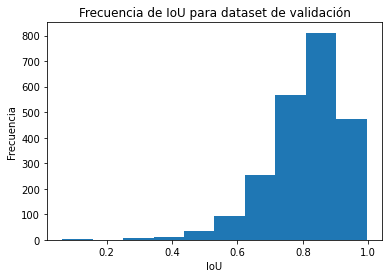

In [ ]:
iou_final(final_model,test_dataset)

In [ ]:
#la salida de la red es un arreglo de 1 fila y 800 columnas, por eso en el codigo se agrega el x[0]
#para indicar que se está trabajando sobre la primera fila y recorriendo las columnas
def umbral(x):
  x_pred = np.zeros(x.shape)    ### PREFIERO HACER UN ARREGLO EXTRA PARA GUARDAR LA PREDICCION PORQUE DE OTRA MANERA A VECES EXISTE RIESGO
  ### DE QUE SE MODIFIQUE EL ARREGLO ORIGINAL Y ESO PUEDE TRAER PROBLEMAS.  NO ESO SI ESO OCURRE EXACTAMENTE EN ESTE CASO PERO YO PREFIERO
  ### TOMAR LOS RESGUARDOS jaja.
  for i in range(len(x[0])): 
    if x[0][i]>0.4:
      x_pred[0][i]=1
    #else:
    #  x[0][i]=0         ### EL ARREGLO x_pred YA ESTÁ INICIALIZADO EN 0s
  return x_pred


index = 50

example_image, example_class = test_dataset[index]
#a=umbral(example_image)                                ### ESTABAN APLICANDO ESTO EN LA SEÑAL DIRECTAMENTE, NO LA ESTABAN PASANDO POR EL MODELO!!
#a
print(len(test_dataset))


2256


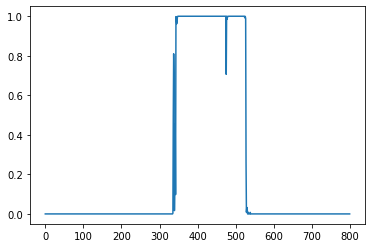

CNNModel2(
  (conv_blocks): Sequential(
    (0): Conv1d(1, 20, kernel_size=(200,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(20, 15, kernel_size=(100,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(15, 10, kernel_size=(50,), stride=(1,), padding=same)
    (5): ReLU()
    (6): Conv1d(10, 1, kernel_size=(20,), stride=(1,), padding=same)
    (7): ReLU()
  )
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=800, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=800, bias=True)
    (5): Sigmoid()
  )
  (net): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 20, kernel_size=(200,), stride=(1,), padding=same)
      (1): ReLU()
      (2): Conv1d(20, 15, kernel_size=(100,), stride=(1,), padding=same)
      (3): ReLU()
      (4): Conv1d(15, 10, kernel_size=(50,), stride=(1,), padding=same)
      (5): ReLU()
      (6): Conv1d(10, 1, kernel_si

In [ ]:
### COMPROBEMOS QUE LA SALIDA DE LA RED SON PROBABILIDADES (ES DECIR ENTRE 0 y 1)
plt.plot(final_model(example_image).detach().numpy().squeeze())
plt.show()
print(final_model)

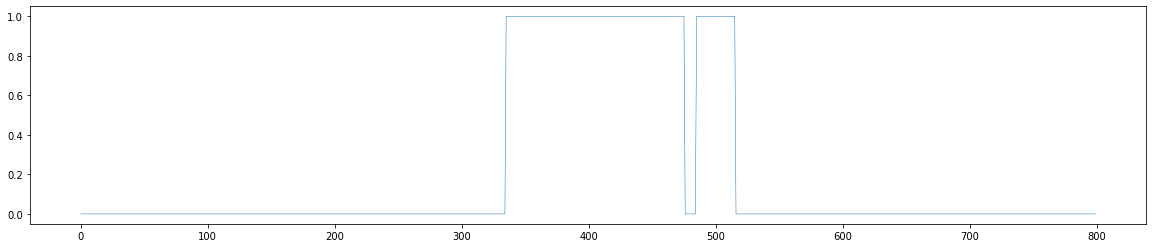

In [ ]:
### AHORA SI
a = umbral(final_model(example_image))
plt.figure(figsize=(20,4))
plt.plot(a[0], linewidth=0.5)
plt.show()

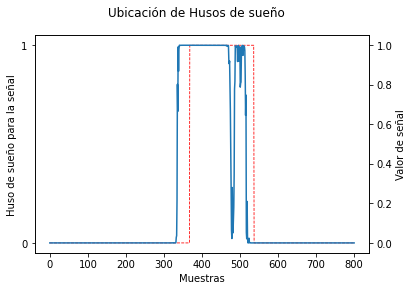

In [ ]:
#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()

# Crear la figura y los ejes


fig, ax = plt.subplots()
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze())
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

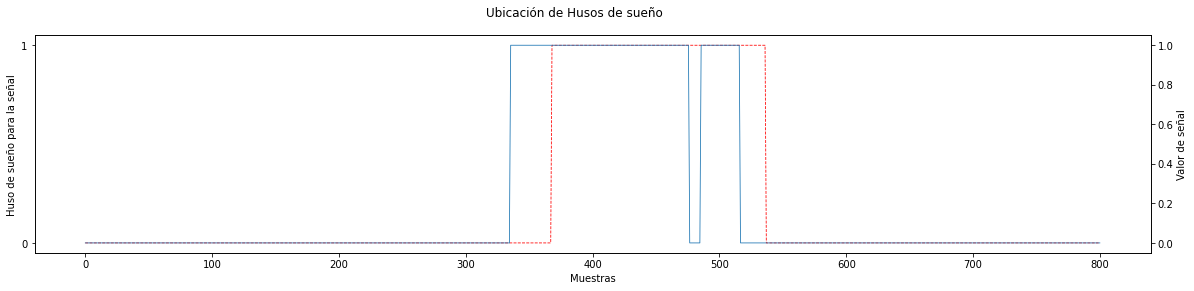

In [ ]:
#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(20,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

**Criterio para hacer predicción segmento continuo**

In [ ]:
def linealizar_resultado(test_dataset,indice):
  index = indice

  example_image, example_class = test_dataset[index]
  example_image= final_model(example_image).detach().numpy()
  example_image=umbral(example_image)
  example_image = example_image.squeeze()

  inicio = 0

  for i in range(len(example_image)):
    if example_image[i] == 1:
      inicio = i
      break 
    

  for j in reversed(range(len(example_image))):
    if example_image[j] == 1:
      final = j
      break

  x_lin = np.zeros(example_image.shape[0])
  for h in range(len(x_lin)):
    if h >= inicio and h<= final:
      x_lin[h]=1

  return x_lin


In [ ]:
x_lin = linealizar_resultado(test_dataset,50)
print(x_lin)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

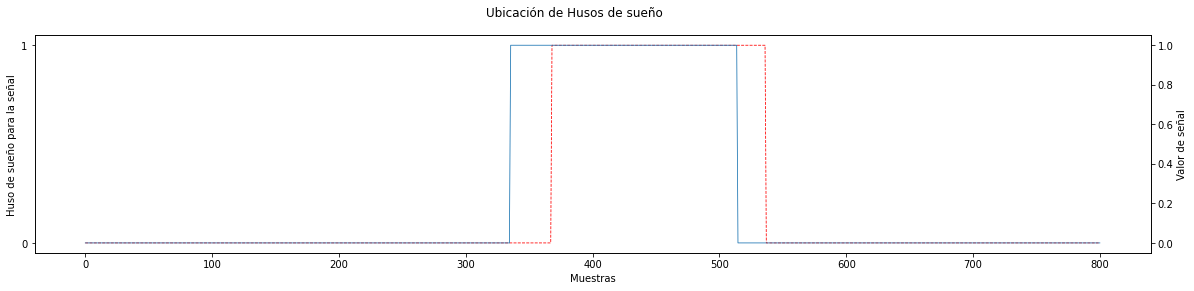

In [ ]:
muestras=np.linspace(0, 800, num=800)

fig, ax = plt.subplots(figsize=(20,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, x_lin, linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


In [ ]:
def obt_puntos(x_lin,marks):
  for i in range(800):
    if x_lin[i]==1:
      inicio_pred = i
      break
  for j in range(800):
    if marks[j]==1:
      inicio_marks = j
      break
  for o in reversed(range(800)):
    if x_lin[o]==1:
      final_pred = o
      break
  for p in reversed(range(800)):
    if marks[p]==1:
      final_marks = p
      break
  return (inicio_pred,final_pred,inicio_marks,final_marks)


In [ ]:
a = obt_puntos(x_lin,example_class)
pre = a[0],a[1]
mark = a[2],a[3]
print(pre,mark)

(335, 513) (368, 536)


In [ ]:
def iou(prediction,mark):
  #Tomo el comienzo y el final de la prediccion y los label
  x1_p=prediction[0]
  x2_p=prediction[1]
  x1_m=mark[0]
  x2_m=mark[1]

  #para la unión
  x1_u = min(x1_p,x1_m)
  x2_u = max(x2_p,x2_m)
  u_long = x2_u - x1_u + 1

  #para la intersección
  x1_i = max(x1_p,x1_m)
  x2_i = min(x2_p,x2_m)
  i_long = x2_i - x1_i + 1

  #iou
  resultado = i_long / u_long

  return resultado
  

In [ ]:
iou(pre,mark)

0.7227722772277227

# **Buscando la mejor red**

Red con 3 capas convolucionales y 1 capa en red mlp simple

In [ ]:
class CNNModel(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 16, kernel_size=1), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(16, 32, kernel_size=1),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(32, 1, kernel_size=1),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

Epoch 1/15
Iteration 5 - Batch 5/140 - Train loss: 0.6907152136166891, Train acc: 0.548359375
Iteration 10 - Batch 10/140 - Train loss: 0.684301267970692, Train acc: 0.6171875
Iteration 15 - Batch 15/140 - Train loss: 0.6670084409415722, Train acc: 0.66464599609375
Iteration 20 - Batch 20/140 - Train loss: 0.6338163898104713, Train acc: 0.6923939732142858
Iteration 25 - Batch 25/140 - Train loss: 0.594008771272806, Train acc: 0.7101502403846154
Iteration 30 - Batch 30/140 - Train loss: 0.5632607638835907, Train acc: 0.7220917338709677
Iteration 35 - Batch 35/140 - Train loss: 0.5394647171099981, Train acc: 0.7302072482638889
Iteration 40 - Batch 40/140 - Train loss: 0.5208641763140516, Train acc: 0.7351067073170732
Iteration 45 - Batch 45/140 - Train loss: 0.5061843641426252, Train acc: 0.738784816576087
Iteration 50 - Batch 50/140 - Train loss: 0.4942139708528332, Train acc: 0.7425122549019608
Iteration 55 - Batch 55/140 - Train loss: 0.4835971077638013, Train acc: 0.7466350446428571


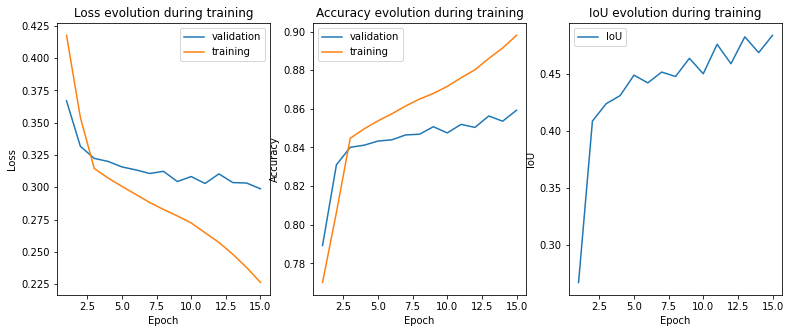

In [ ]:
lr = 5e-4
dropout_p = 0.5
batch_size = 32
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel(dropout_p=0.1)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)

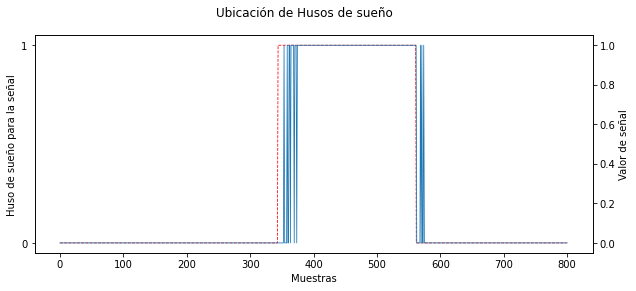

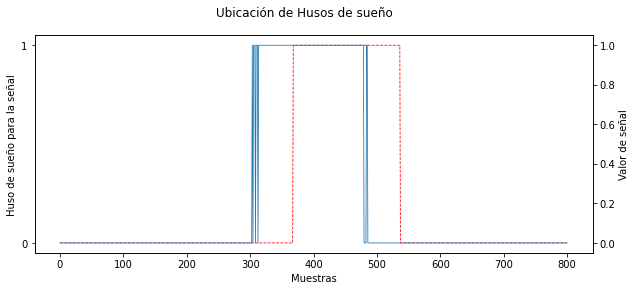

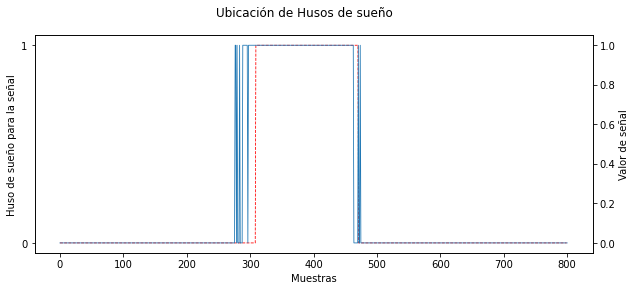

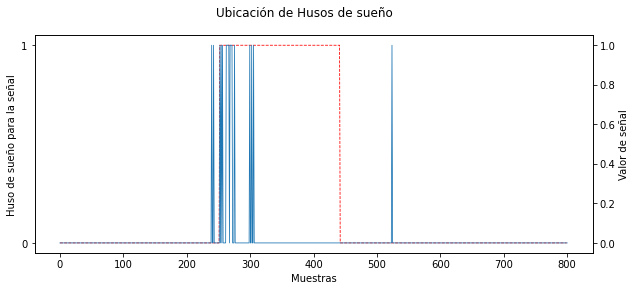

In [ ]:
#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 15, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(15, 10,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(10, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6714817484219869, Train acc: 0.5975416666666666
Iteration 10 - Batch 10/298 - Train loss: 0.5830587121573362, Train acc: 0.6746363636363636
Iteration 15 - Batch 15/298 - Train loss: 0.533438216894865, Train acc: 0.7018385416666667
Iteration 20 - Batch 20/298 - Train loss: 0.4992050471759978, Train acc: 0.7200357142857143


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


Iteration 25 - Batch 25/298 - Train loss: 0.4761136013727922, Train acc: 0.7331442307692307
Iteration 30 - Batch 30/298 - Train loss: 0.4569418516851241, Train acc: 0.7444516129032258
Iteration 35 - Batch 35/298 - Train loss: 0.44478430764542687, Train acc: 0.7514375
Iteration 40 - Batch 40/298 - Train loss: 0.4302388764009243, Train acc: 0.7615772357723577
Iteration 45 - Batch 45/298 - Train loss: 0.41196170092924783, Train acc: 0.7749547101449276
Iteration 50 - Batch 50/298 - Train loss: 0.39517730445254085, Train acc: 0.786609477124183
Iteration 55 - Batch 55/298 - Train loss: 0.37894781599087374, Train acc: 0.797686011904762
Iteration 60 - Batch 60/298 - Train loss: 0.3644725968603228, Train acc: 0.8076994535519125
Iteration 65 - Batch 65/298 - Train loss: 0.3510557097015959, Train acc: 0.8162449494949495
Iteration 70 - Batch 70/298 - Train loss: 0.3396004851855023, Train acc: 0.8239483568075118
Iteration 75 - Batch 75/298 - Train loss: 0.32919931666631447, Train acc: 0.83064473684

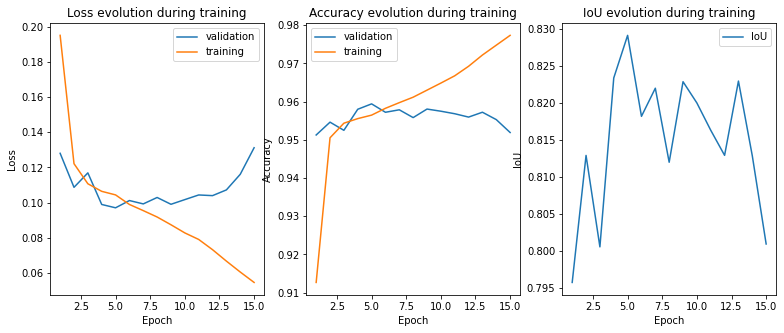

In [ ]:
lr = 0.001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.1)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)

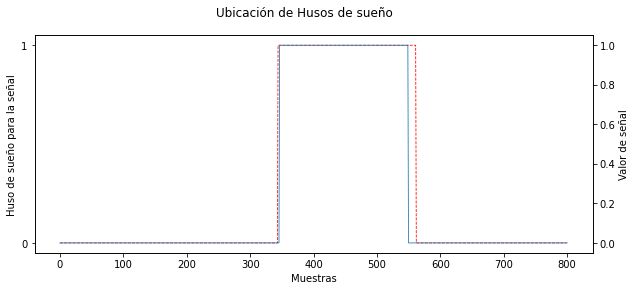

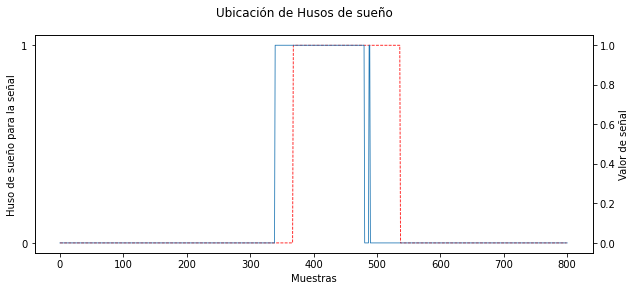

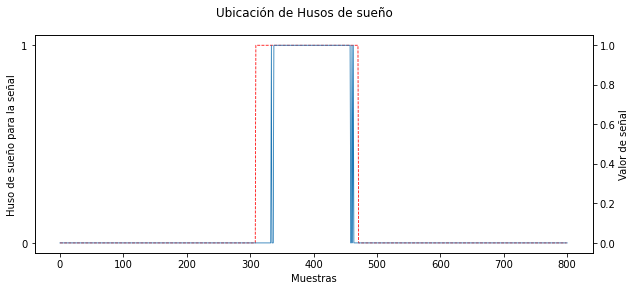

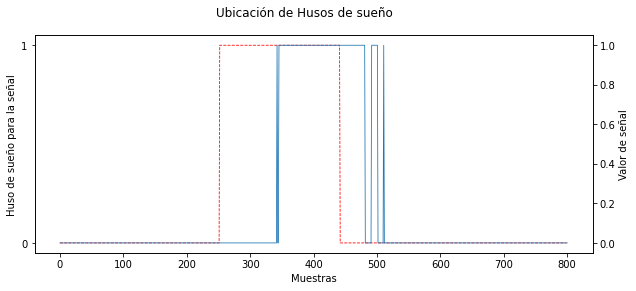

In [ ]:
#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

último modelo da mejores resultados, por lo que intentaremos variar sus parametros para obtener mejores resultados 

aumento de drop out a 0.5

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6809770464897156, Train acc: 0.5799027777777778
Iteration 10 - Batch 10/298 - Train loss: 0.6178968386216597, Train acc: 0.6482575757575758
Iteration 15 - Batch 15/298 - Train loss: 0.5675890054553747, Train acc: 0.68590625
Iteration 20 - Batch 20/298 - Train loss: 0.5360230533849626, Train acc: 0.7043809523809523
Iteration 25 - Batch 25/298 - Train loss: 0.511803055038819, Train acc: 0.7178205128205128
Iteration 30 - Batch 30/298 - Train loss: 0.49230407418743255, Train acc: 0.727758064516129
Iteration 35 - Batch 35/298 - Train loss: 0.4781965853439437, Train acc: 0.7349814814814815
Iteration 40 - Batch 40/298 - Train loss: 0.4675215460905215, Train acc: 0.7403008130081301
Iteration 45 - Batch 45/298 - Train loss: 0.45925080322701, Train acc: 0.744052536231884
Iteration 50 - Batch 50/298 - Train loss: 0.4535355024478015, Train acc: 0.7466993464052287
Iteration 55 - Batch 55/298 - Train loss: 0.4476470287357058, Train acc: 0.74980654

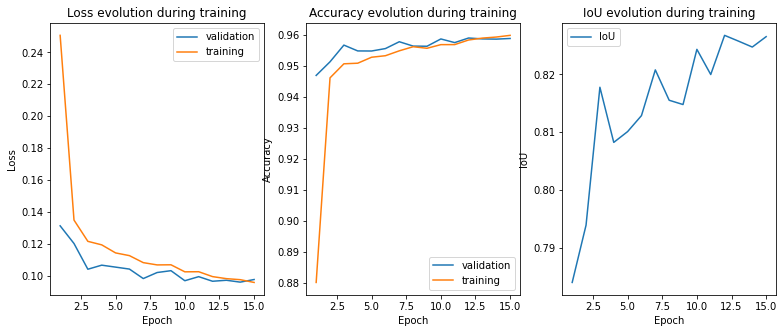

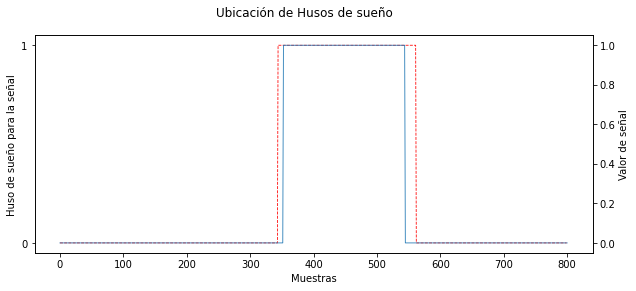

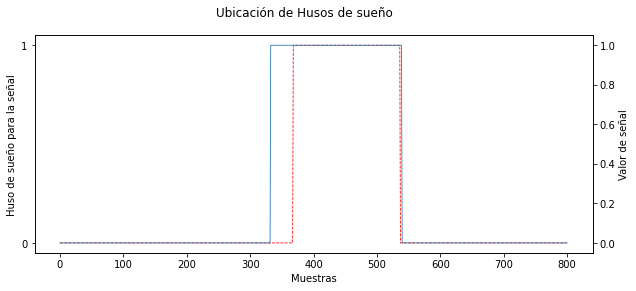

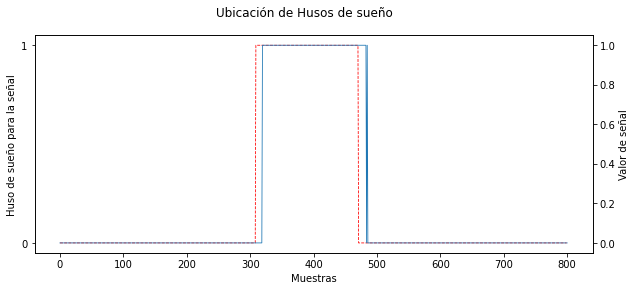

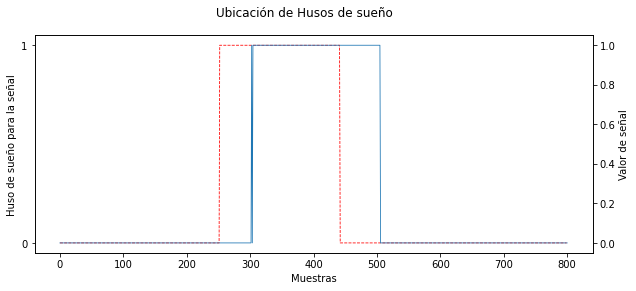

In [ ]:
lr = 0.001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

dropout mejora los resultados. Ahora veremos el número de epocas aumentandolas

Epoch 1/25
Iteration 5 - Batch 5/298 - Train loss: 0.6746534009774526, Train acc: 0.5733333333333334
Iteration 10 - Batch 10/298 - Train loss: 0.6072636111216112, Train acc: 0.6480530303030303
Iteration 15 - Batch 15/298 - Train loss: 0.5558570064604282, Train acc: 0.6863854166666666
Iteration 20 - Batch 20/298 - Train loss: 0.5247223973274231, Train acc: 0.7067936507936508
Iteration 25 - Batch 25/298 - Train loss: 0.5028184549166606, Train acc: 0.7199807692307693
Iteration 30 - Batch 30/298 - Train loss: 0.48365158996274393, Train acc: 0.7304919354838709
Iteration 35 - Batch 35/298 - Train loss: 0.47168823414378697, Train acc: 0.737125
Iteration 40 - Batch 40/298 - Train loss: 0.4620351725962104, Train acc: 0.7423577235772357
Iteration 45 - Batch 45/298 - Train loss: 0.45265941062699194, Train acc: 0.7480054347826087
Iteration 50 - Batch 50/298 - Train loss: 0.4460175826269038, Train acc: 0.7530277777777777
Iteration 55 - Batch 55/298 - Train loss: 0.4363964945077896, Train acc: 0.760

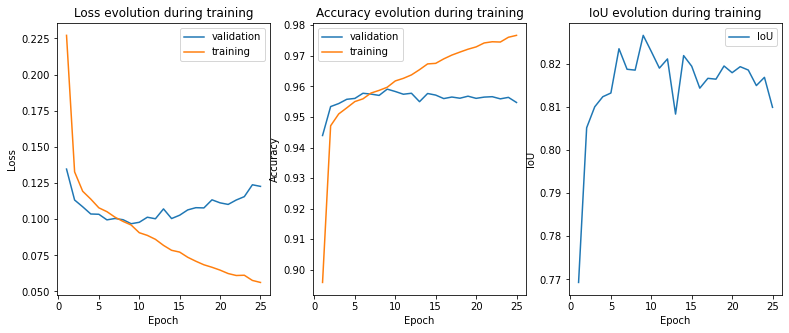

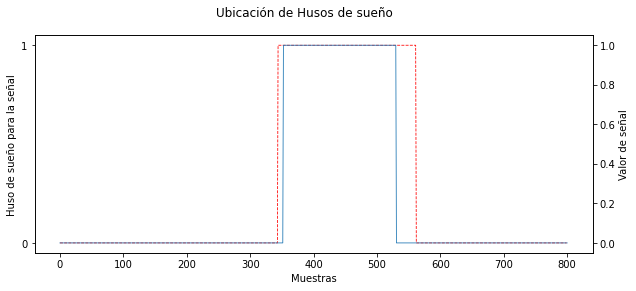

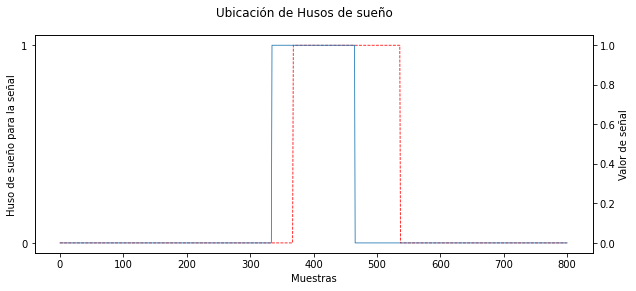

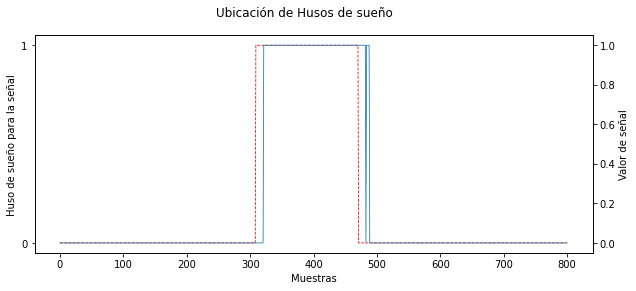

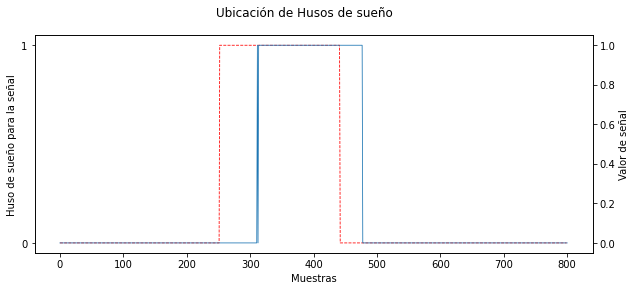

In [ ]:
lr = 0.001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 25
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

dejaremos el número de epocas en 15. Ahora veremos el learning rate disminuyendolo y aumentandolo

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6932920217514038, Train acc: 0.4979166666666667
Iteration 10 - Batch 10/298 - Train loss: 0.6923837824301287, Train acc: 0.511560606060606
Iteration 15 - Batch 15/298 - Train loss: 0.6903078593313694, Train acc: 0.532421875
Iteration 20 - Batch 20/298 - Train loss: 0.6854577887625921, Train acc: 0.5509920634920635
Iteration 25 - Batch 25/298 - Train loss: 0.6764464791004474, Train acc: 0.567400641025641
Iteration 30 - Batch 30/298 - Train loss: 0.6663681307146626, Train acc: 0.5825591397849462
Iteration 35 - Batch 35/298 - Train loss: 0.6564656413263745, Train acc: 0.5955810185185185
Iteration 40 - Batch 40/298 - Train loss: 0.6466170287713772, Train acc: 0.6078719512195122
Iteration 45 - Batch 45/298 - Train loss: 0.636724282865939, Train acc: 0.619159420289855
Iteration 50 - Batch 50/298 - Train loss: 0.6277657478463416, Train acc: 0.6289738562091504
Iteration 55 - Batch 55/298 - Train loss: 0.6165405714086124, Train acc: 0.6394375

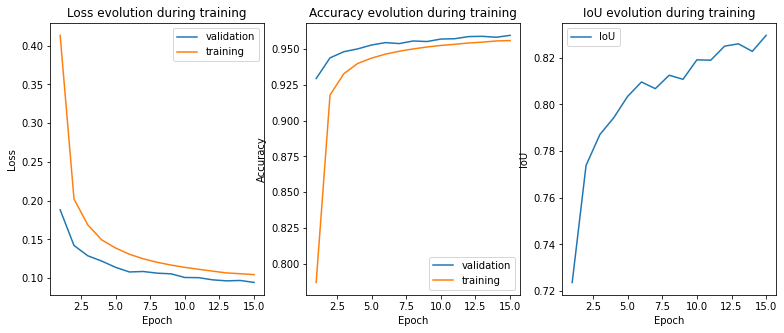

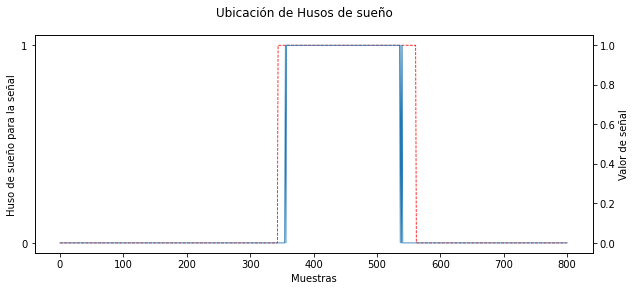

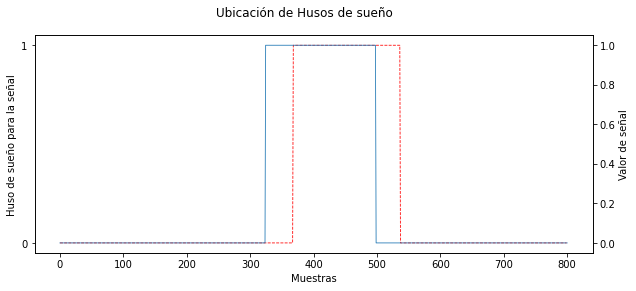

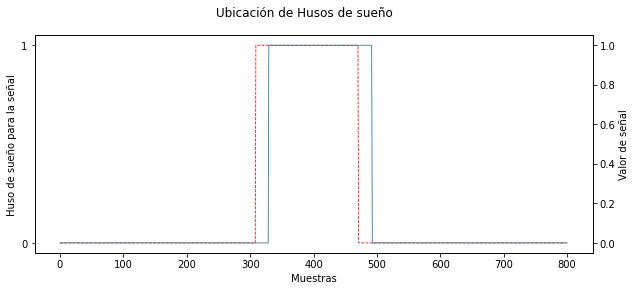

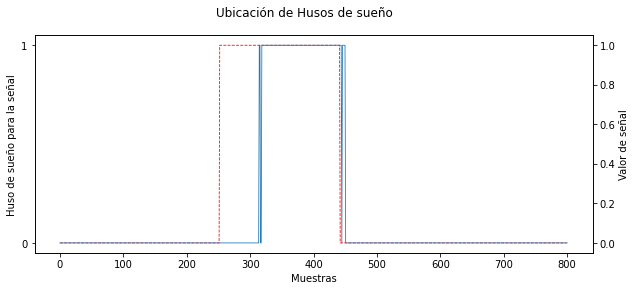

In [ ]:
lr = 0.0001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

aumentamos lr

```
# Tiene formato de código
```



Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6641151507695516, Train acc: 0.7035277777777778
Iteration 10 - Batch 10/298 - Train loss: 0.6115501523017883, Train acc: 0.7424924242424242
Iteration 15 - Batch 15/298 - Train loss: 0.5614000782370567, Train acc: 0.755578125
Iteration 20 - Batch 20/298 - Train loss: 0.520221376702899, Train acc: 0.7629285714285714
Iteration 25 - Batch 25/298 - Train loss: 0.4984539758700591, Train acc: 0.7652339743589743
Iteration 30 - Batch 30/298 - Train loss: 0.4796024012950159, Train acc: 0.7667768817204301
Iteration 35 - Batch 35/298 - Train loss: 0.4663786855008867, Train acc: 0.7694375
Iteration 40 - Batch 40/298 - Train loss: 0.45488776811739295, Train acc: 0.7711768292682927
Iteration 45 - Batch 45/298 - Train loss: 0.4462550075157829, Train acc: 0.7711413043478261
Iteration 50 - Batch 50/298 - Train loss: 0.44041953659525107, Train acc: 0.7712042483660131
Iteration 55 - Batch 55/298 - Train loss: 0.43288354575634, Train acc: 0.7731532738095

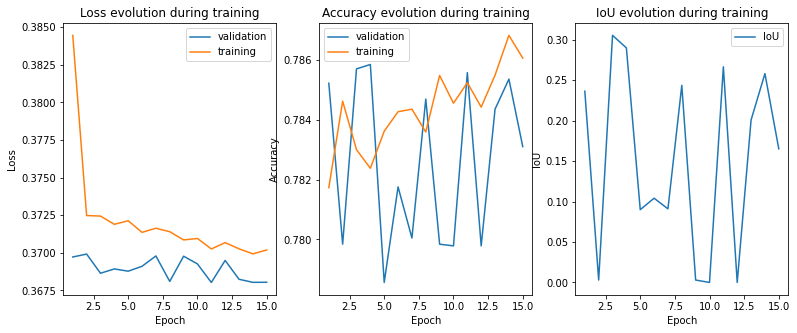

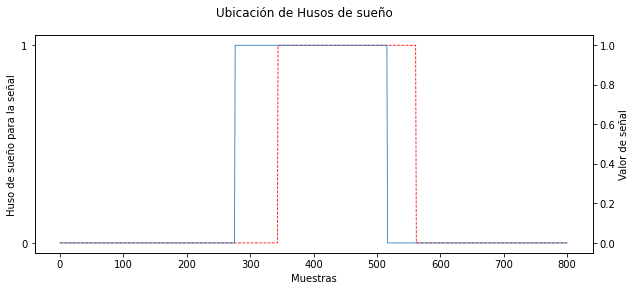

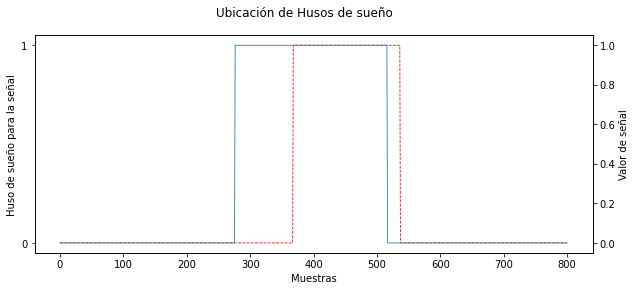

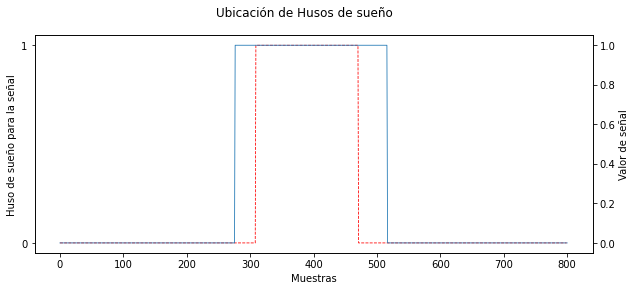

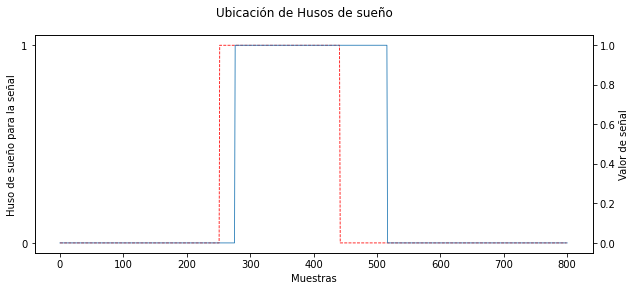

In [ ]:
lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

dejamos lr en el valor  que tenia, y variamos los batches en 100 y 5

Epoch 1/15
Iteration 5 - Batch 5/45 - Train loss: 0.6545744836330414, Train acc: 0.711225
Iteration 10 - Batch 10/45 - Train loss: 0.5854816301302477, Train acc: 0.7466045454545455
Iteration 15 - Batch 15/45 - Train loss: 0.5304097216576338, Train acc: 0.7589375
Iteration 20 - Batch 20/45 - Train loss: 0.49844389586221605, Train acc: 0.7644809523809524
Iteration 25 - Batch 25/45 - Train loss: 0.47425150871276855, Train acc: 0.7682163461538462
Iteration 30 - Batch 30/45 - Train loss: 0.45869306402821697, Train acc: 0.7700298387096774
Iteration 35 - Batch 35/45 - Train loss: 0.4474809749258889, Train acc: 0.772196875
Iteration 40 - Batch 40/45 - Train loss: 0.4383596203676084, Train acc: 0.7735905487804878
Val loss: 0.36973132271515696, Val acc: 0.7845824115044248, IoU: 0.2531639501438098
Epoch 2/15
Iteration 5 - Batch 5/45 - Train loss: 0.37165877719720203, Train acc: 0.783425
Iteration 10 - Batch 10/45 - Train loss: 0.37238041921095416, Train acc: 0.7835784090909091
Iteration 15 - Batc

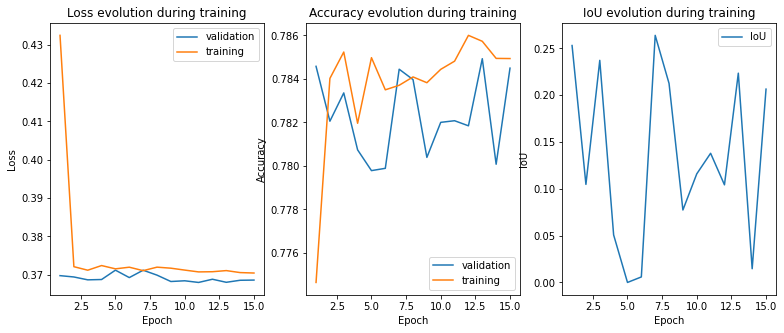

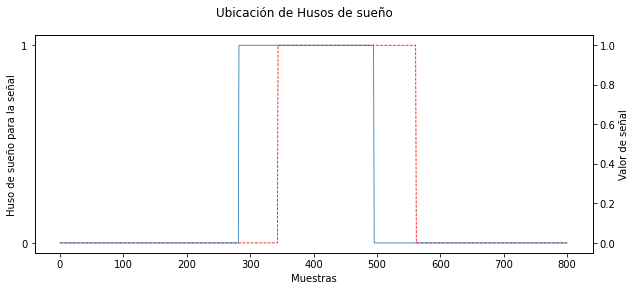

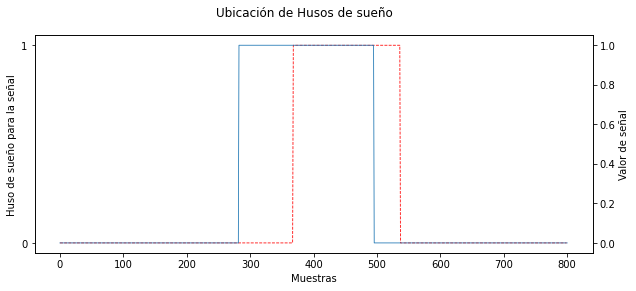

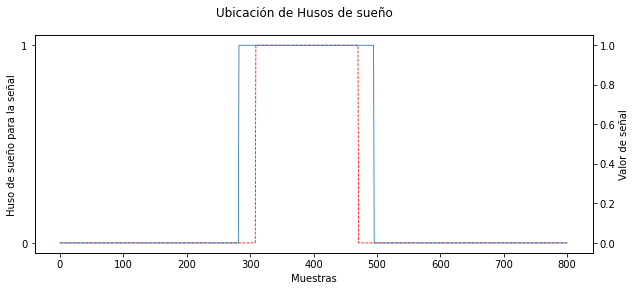

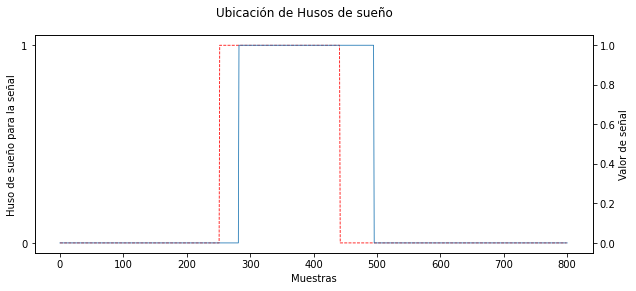

In [ ]:
lr = 0.01
dropout_p = 0.5
batch_size = 100
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

Epoch 1/15
Iteration 5 - Batch 5/893 - Train loss: 0.6640618344148, Train acc: 0.6987083333333334
Iteration 10 - Batch 10/893 - Train loss: 0.6115743680433794, Train acc: 0.7406818181818182
Iteration 15 - Batch 15/893 - Train loss: 0.55874302983284, Train acc: 0.759484375
Iteration 20 - Batch 20/893 - Train loss: 0.516661775963647, Train acc: 0.7668928571428572
Iteration 25 - Batch 25/893 - Train loss: 0.4868174825723355, Train acc: 0.7724423076923077
Iteration 30 - Batch 30/893 - Train loss: 0.4600190097285855, Train acc: 0.7808467741935484
Iteration 35 - Batch 35/893 - Train loss: 0.45491381569041145, Train acc: 0.77825
Iteration 40 - Batch 40/893 - Train loss: 0.4502683310973935, Train acc: 0.77575
Iteration 45 - Batch 45/893 - Train loss: 0.4451241758854493, Train acc: 0.7755923913043479
Iteration 50 - Batch 50/893 - Train loss: 0.43754587629262137, Train acc: 0.7766960784313726
Iteration 55 - Batch 55/893 - Train loss: 0.43028417069997105, Train acc: 0.7785535714285714
Iteration 6

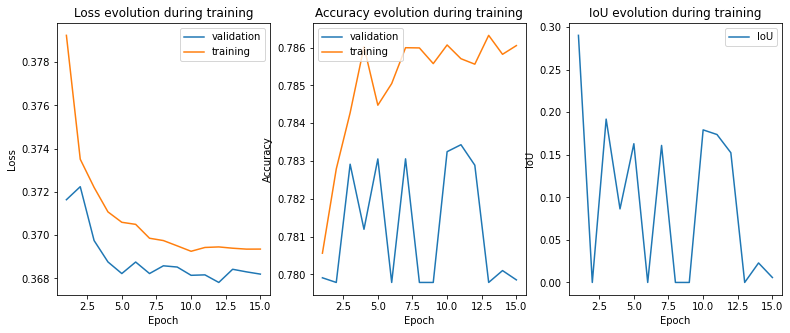

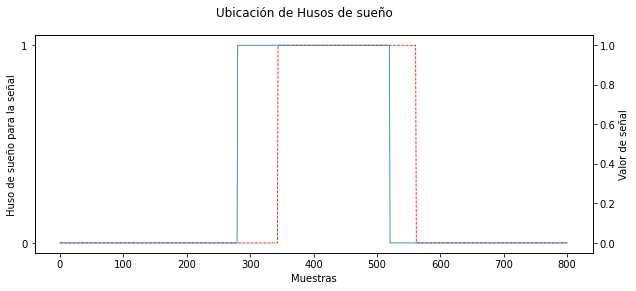

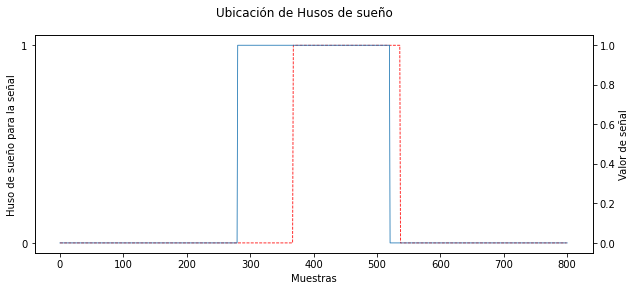

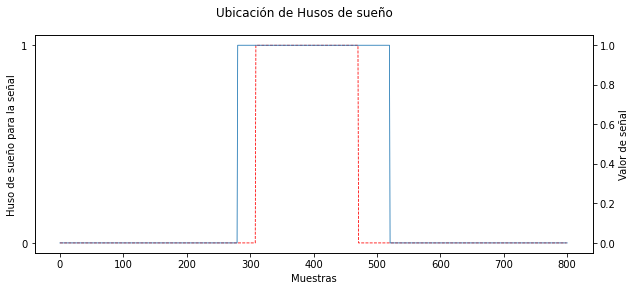

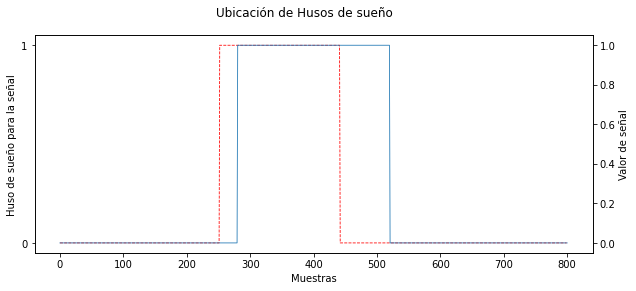

In [ ]:
lr = 0.01
dropout_p = 0.5
batch_size = 5
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

batches de 25

Epoch 1/15
Iteration 5 - Batch 5/179 - Train loss: 3.702188620964686, Train acc: 0.7142583333333333
Iteration 10 - Batch 10/179 - Train loss: 2.282453390684995, Train acc: 0.7475636363636363
Iteration 15 - Batch 15/179 - Train loss: 1.71229219250381, Train acc: 0.757196875
Iteration 20 - Batch 20/179 - Train loss: 1.3979829592364175, Train acc: 0.7618333333333334
Iteration 25 - Batch 25/179 - Train loss: 1.2025337723585277, Train acc: 0.7657788461538462
Iteration 30 - Batch 30/179 - Train loss: 1.0705706342574088, Train acc: 0.7679387096774194
Iteration 35 - Batch 35/179 - Train loss: 0.973552967939112, Train acc: 0.7702041666666667
Iteration 40 - Batch 40/179 - Train loss: 0.9006512172338439, Train acc: 0.7711939024390244
Iteration 45 - Batch 45/179 - Train loss: 0.8424748823694561, Train acc: 0.7728217391304348
Iteration 50 - Batch 50/179 - Train loss: 0.796639618920345, Train acc: 0.7739931372549019
Iteration 55 - Batch 55/179 - Train loss: 0.7596179683293615, Train acc: 0.774230357

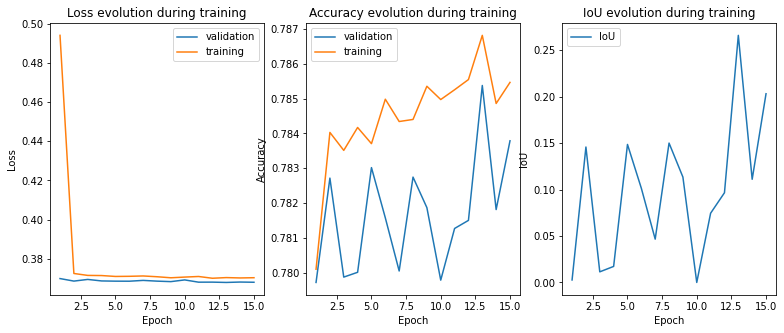

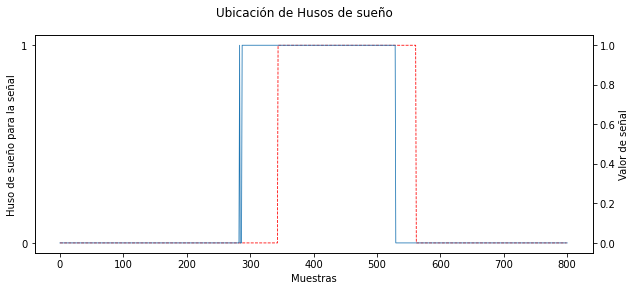

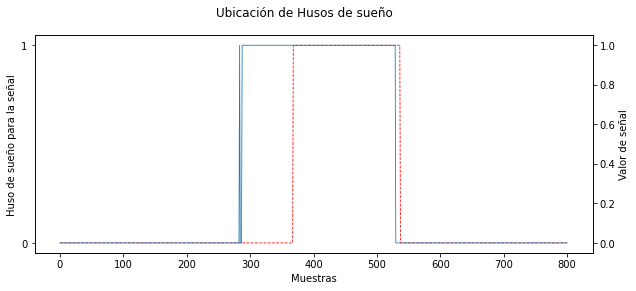

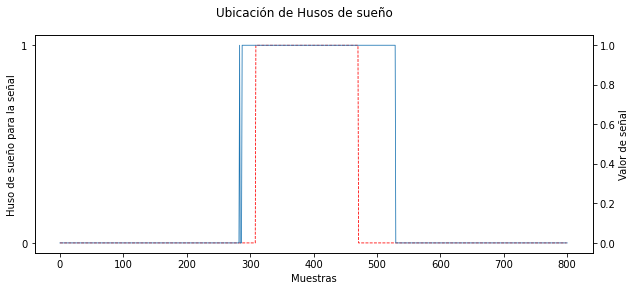

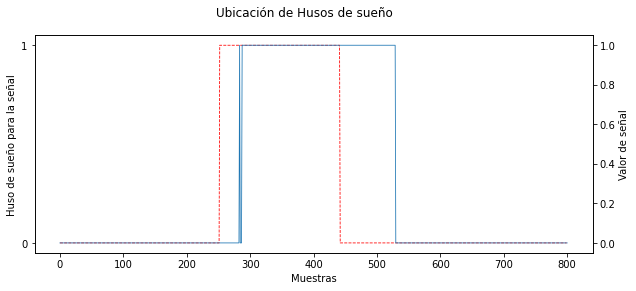

In [ ]:
lr = 0.01
dropout_p = 0.5
batch_size = 25
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

dejamos en 15 los batches. procedemos a modificar la arquitectura de la red poniendo una capa mas a la red MLP

In [ ]:
class CNNModel3(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 15, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(15, 10,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(10, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(300,800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.5854111959536871, Train acc: 0.7462777777777778
Iteration 10 - Batch 10/298 - Train loss: 0.5154181637547233, Train acc: 0.7627727272727273
Iteration 15 - Batch 15/298 - Train loss: 0.47531068325042725, Train acc: 0.7691302083333333
Iteration 20 - Batch 20/298 - Train loss: 0.45635967595236643, Train acc: 0.7701388888888889
Iteration 25 - Batch 25/298 - Train loss: 0.44578051567077637, Train acc: 0.7669102564102565
Iteration 30 - Batch 30/298 - Train loss: 0.43678002203664473, Train acc: 0.7677419354838709
Iteration 35 - Batch 35/298 - Train loss: 0.42851733913024265, Train acc: 0.7702638888888889
Iteration 40 - Batch 40/298 - Train loss: 0.42467404066062553, Train acc: 0.7688536585365854
Iteration 45 - Batch 45/298 - Train loss: 0.41916381470535113, Train acc: 0.7695634057971015
Iteration 50 - Batch 50/298 - Train loss: 0.4152243780154808, Train acc: 0.7706911764705883
Iteration 55 - Batch 55/298 - Train loss: 0.41211147446717533, T

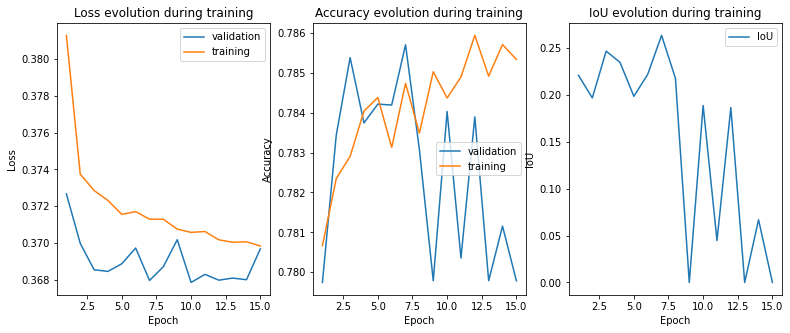

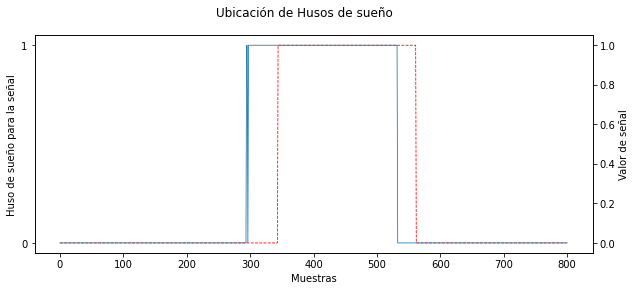

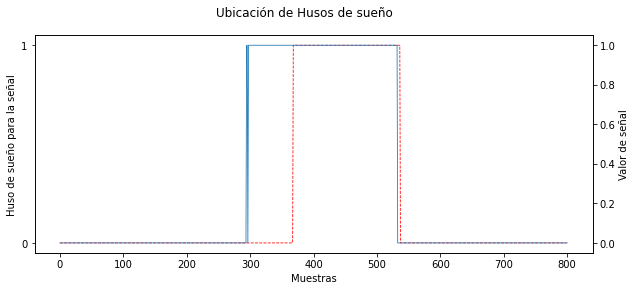

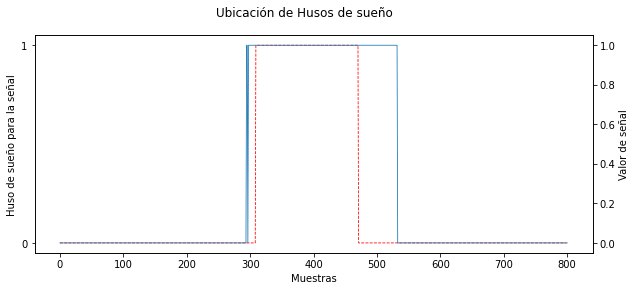

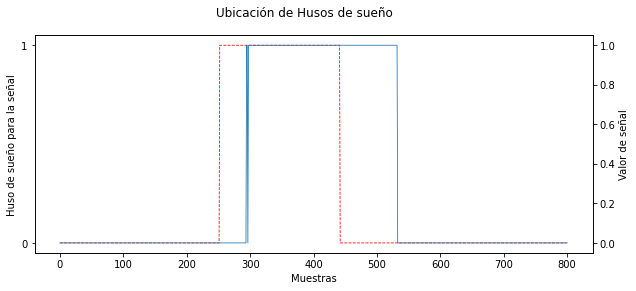

In [ ]:
lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel3(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

otra capa mas la la red MLP

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 1.6004327336947124, Train acc: 0.7168194444444445
Iteration 10 - Batch 10/298 - Train loss: 1.0712553831663998, Train acc: 0.7346666666666667
Iteration 15 - Batch 15/298 - Train loss: 0.8575727920979261, Train acc: 0.7475052083333333
Iteration 20 - Batch 20/298 - Train loss: 0.7473948739823841, Train acc: 0.7536111111111111
Iteration 25 - Batch 25/298 - Train loss: 0.6743851132117785, Train acc: 0.7604166666666666
Iteration 30 - Batch 30/298 - Train loss: 0.6267667191643869, Train acc: 0.765774193548387
Iteration 35 - Batch 35/298 - Train loss: 0.5935807435048951, Train acc: 0.7671805555555555
Iteration 40 - Batch 40/298 - Train loss: 0.5656756904067063, Train acc: 0.7703394308943089
Iteration 45 - Batch 45/298 - Train loss: 0.5458204402871754, Train acc: 0.7700072463768116
Iteration 50 - Batch 50/298 - Train loss: 0.53029624153586, Train acc: 0.7709460784313725
Iteration 55 - Batch 55/298 - Train loss: 0.5161887790475573, Train acc: 0

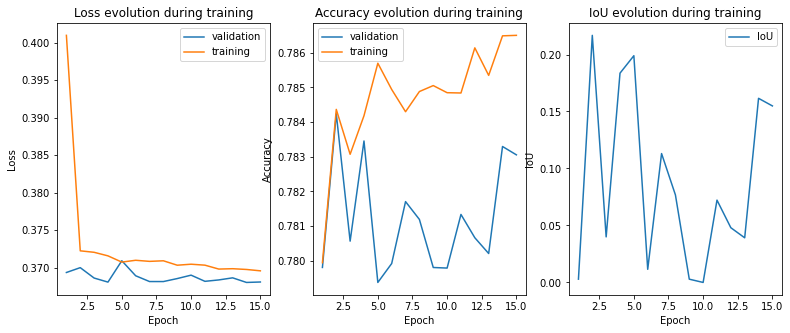

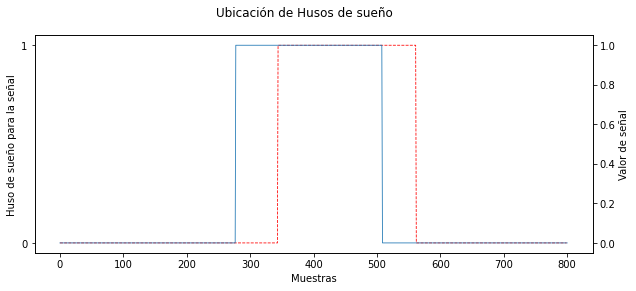

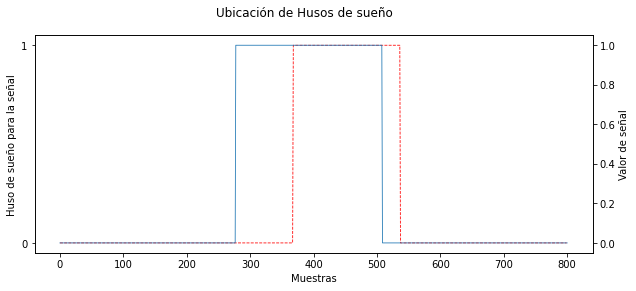

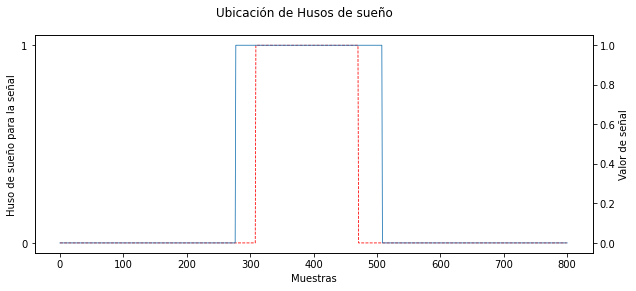

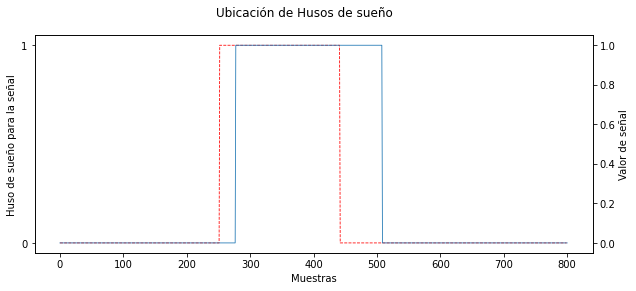

In [ ]:
class CNNModel4(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 15, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(15, 10,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(10, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(300,500),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(500,800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)



lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel4(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

dejamos la red con las capas mlp anteriores, y procedemos a modificar la capa convolucional agregando otro bloque

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 6.304751694202423, Train acc: 0.7330972222222222
Iteration 10 - Batch 10/298 - Train loss: 3.6206524019891564, Train acc: 0.7546136363636363
Iteration 15 - Batch 15/298 - Train loss: 2.613615471869707, Train acc: 0.7607395833333334
Iteration 20 - Batch 20/298 - Train loss: 2.0853519581613087, Train acc: 0.7612976190476191
Iteration 25 - Batch 25/298 - Train loss: 1.7542709559202194, Train acc: 0.7663269230769231
Iteration 30 - Batch 30/298 - Train loss: 1.5319464475877824, Train acc: 0.7688118279569892
Iteration 35 - Batch 35/298 - Train loss: 1.371563207772043, Train acc: 0.7700717592592593
Iteration 40 - Batch 40/298 - Train loss: 1.2496473883710257, Train acc: 0.7722174796747967
Iteration 45 - Batch 45/298 - Train loss: 1.1553313162015832, Train acc: 0.7726503623188405
Iteration 50 - Batch 50/298 - Train loss: 1.0791449102700925, Train acc: 0.7735294117647059
Iteration 55 - Batch 55/298 - Train loss: 1.0160780660808086, Train acc: 0

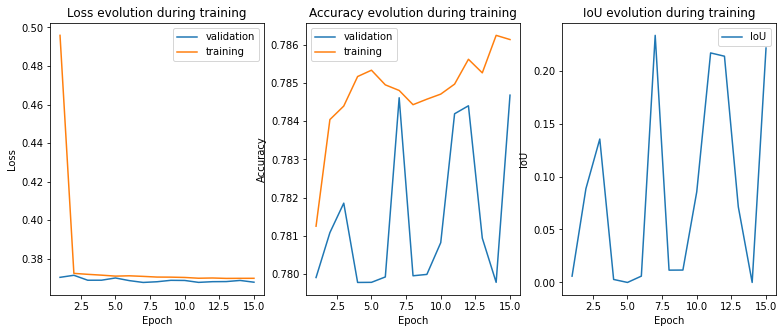

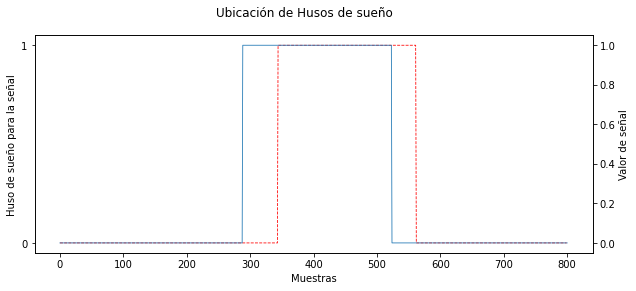

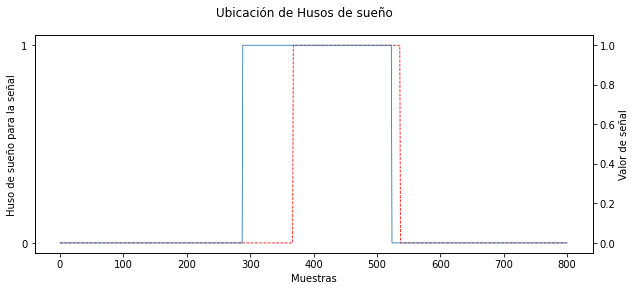

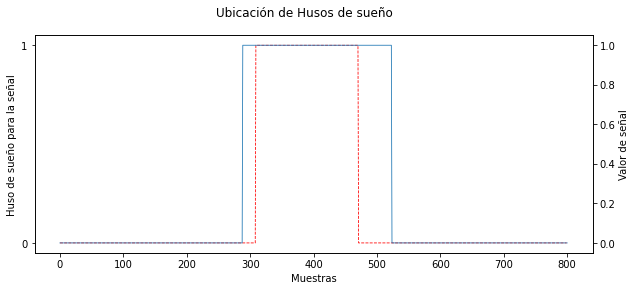

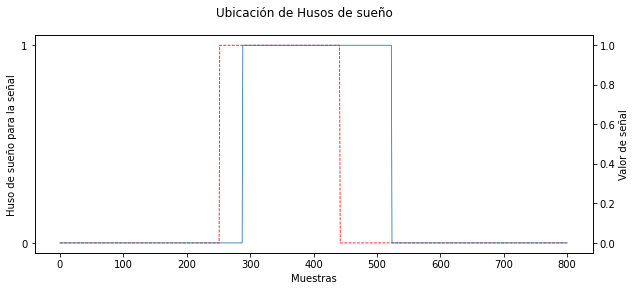

In [ ]:
class CNNModel5(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 15, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(15, 14,  kernel_size=100,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(14, 10,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 5

            nn.Conv1d(10, 1,  kernel_size=50,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(300,500),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(500,800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)



lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel5(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

red convolucional con altas dimensiones de kernels

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 9.807002663612366, Train acc: 0.7356805555555556
Iteration 10 - Batch 10/298 - Train loss: 5.544777889143337, Train acc: 0.7597121212121212
Iteration 15 - Batch 15/298 - Train loss: 3.9355304818600416, Train acc: 0.7644322916666667
Iteration 20 - Batch 20/298 - Train loss: 3.089829284520376, Train acc: 0.768095238095238
Iteration 25 - Batch 25/298 - Train loss: 2.565950232056471, Train acc: 0.7730641025641025
Iteration 30 - Batch 30/298 - Train loss: 2.2137388029406146, Train acc: 0.7727043010752688
Iteration 35 - Batch 35/298 - Train loss: 1.9592728457517095, Train acc: 0.7736296296296297
Iteration 40 - Batch 40/298 - Train loss: 1.7659259990948002, Train acc: 0.7753048780487805
Iteration 45 - Batch 45/298 - Train loss: 1.6127125536618026, Train acc: 0.77775
Iteration 50 - Batch 50/298 - Train loss: 1.4944324341474795, Train acc: 0.7767205882352941
Iteration 55 - Batch 55/298 - Train loss: 1.3952310500400407, Train acc: 0.776766369047

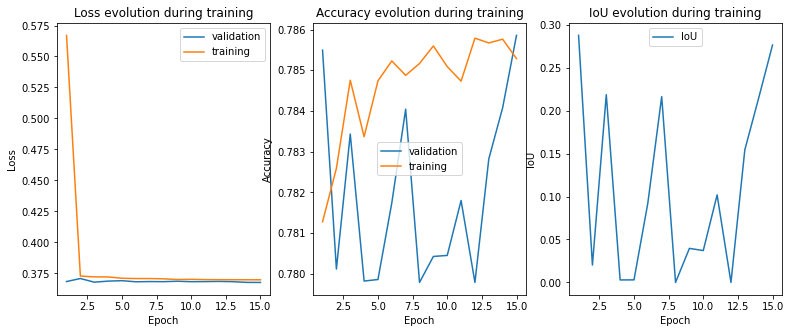

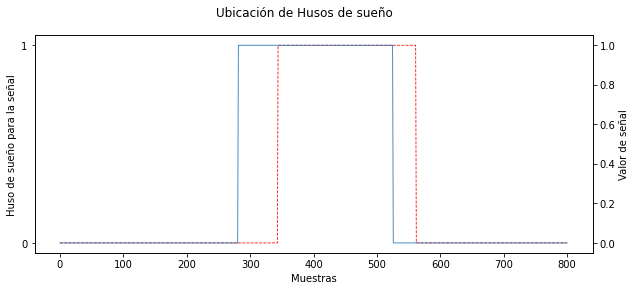

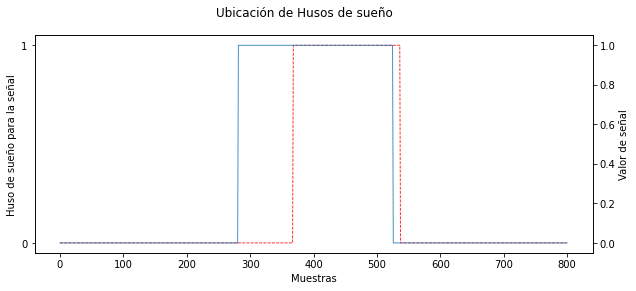

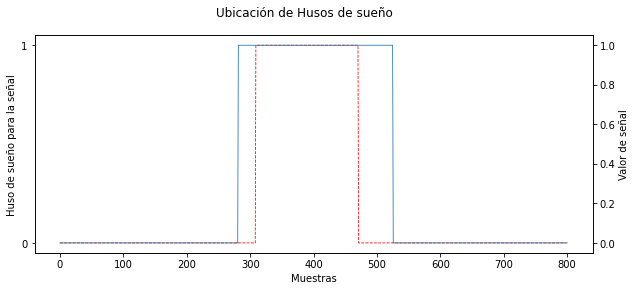

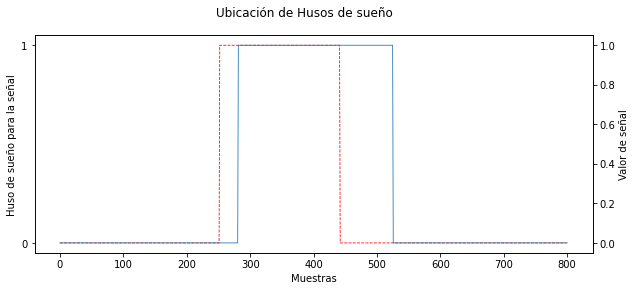

In [ ]:
class CNNModel5(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=1000,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 15, kernel_size=600,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(15, 14,  kernel_size=500,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(14, 10,  kernel_size=300,padding="same"),
            nn.ReLU(),

            # Bloque 5

            nn.Conv1d(10, 1,  kernel_size=100,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(300,500),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(500,800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)



lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel5(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.508092075586319, Train acc: 0.7506111111111111
Iteration 10 - Batch 10/298 - Train loss: 0.46450951424511994, Train acc: 0.7614772727272727
Iteration 15 - Batch 15/298 - Train loss: 0.4440207723528147, Train acc: 0.7617552083333333
Iteration 20 - Batch 20/298 - Train loss: 0.4288353423277537, Train acc: 0.7666507936507937
Iteration 25 - Batch 25/298 - Train loss: 0.4186779283560239, Train acc: 0.7700576923076923
Iteration 30 - Batch 30/298 - Train loss: 0.41255863347361166, Train acc: 0.7726666666666666
Iteration 35 - Batch 35/298 - Train loss: 0.408788800239563, Train acc: 0.7730555555555556
Iteration 40 - Batch 40/298 - Train loss: 0.4042454136580956, Train acc: 0.7742357723577236
Iteration 45 - Batch 45/298 - Train loss: 0.40039874807648035, Train acc: 0.7755579710144928
Iteration 50 - Batch 50/298 - Train loss: 0.39802436793551726, Train acc: 0.7771013071895425
Iteration 55 - Batch 55/298 - Train loss: 0.39692913368344307, Train 

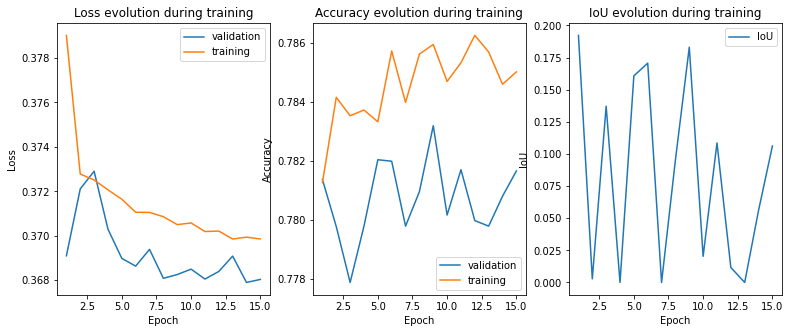

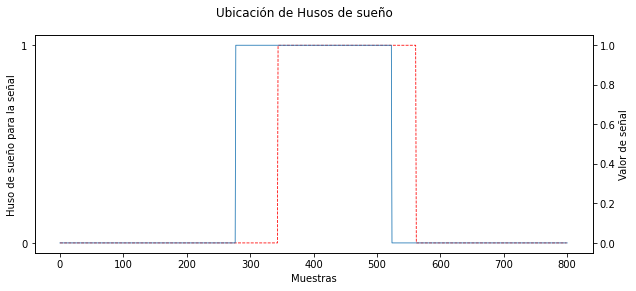

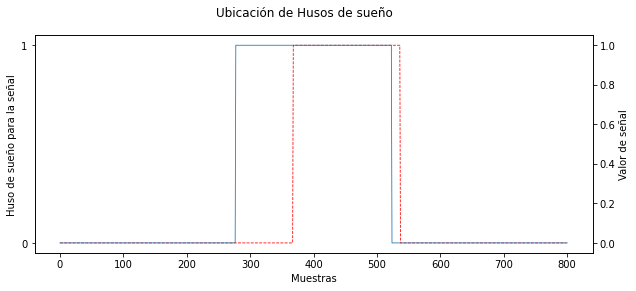

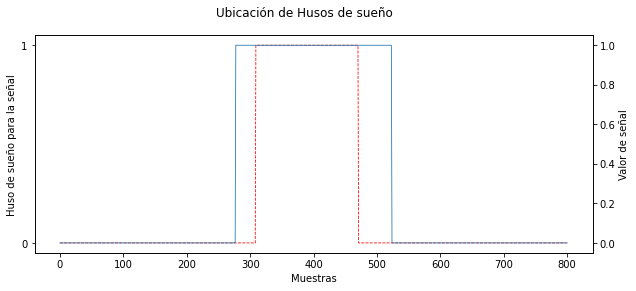

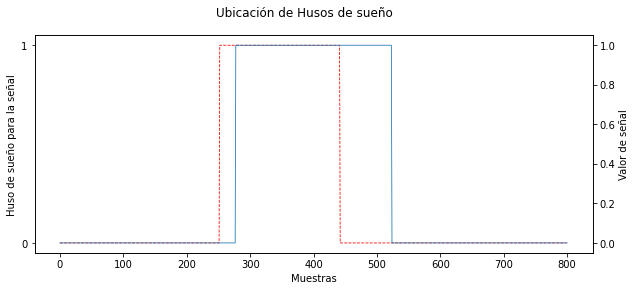

In [ ]:
class CNNModel5(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=60,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 1, kernel_size=50,padding="same"),
            nn.ReLU(),
          

         
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(300,500),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(500,800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)



lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel5(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.949845423301061, Train acc: 0.7143194444444444
Iteration 10 - Batch 10/298 - Train loss: 0.7407551976767454, Train acc: 0.7271212121212122
Iteration 15 - Batch 15/298 - Train loss: 0.6319644451141357, Train acc: 0.735484375
Iteration 20 - Batch 20/298 - Train loss: 0.5766461519967943, Train acc: 0.7452539682539683
Iteration 25 - Batch 25/298 - Train loss: 0.5363686336920812, Train acc: 0.7537083333333333
Iteration 30 - Batch 30/298 - Train loss: 0.5117491877848103, Train acc: 0.7592607526881721
Iteration 35 - Batch 35/298 - Train loss: 0.4943333706922001, Train acc: 0.761662037037037
Iteration 40 - Batch 40/298 - Train loss: 0.4794309728029298, Train acc: 0.7647621951219512
Iteration 45 - Batch 45/298 - Train loss: 0.4681875116151312, Train acc: 0.7676630434782609
Iteration 50 - Batch 50/298 - Train loss: 0.46116726363406463, Train acc: 0.7671846405228758
Iteration 55 - Batch 55/298 - Train loss: 0.45332213970167295, Train acc: 0.768

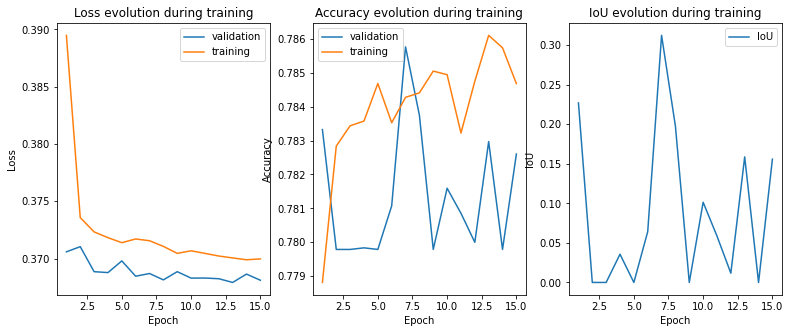

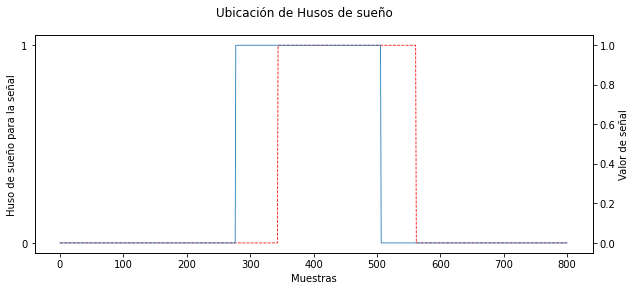

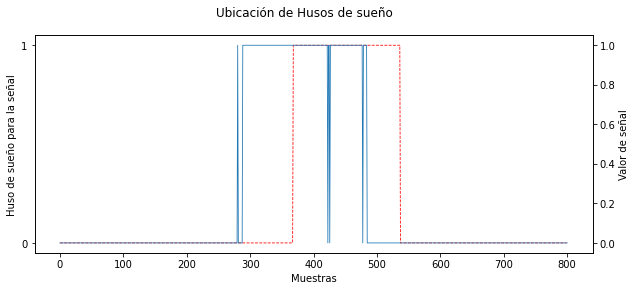

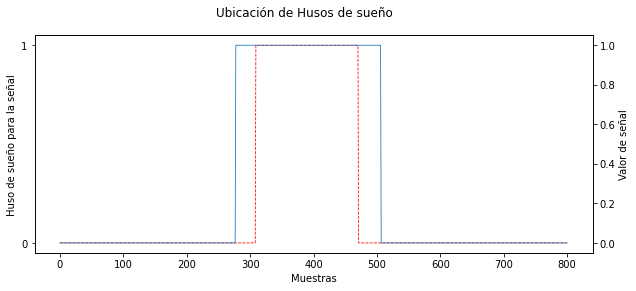

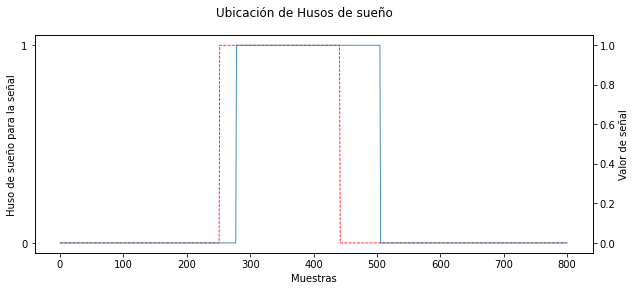

In [ ]:
class CNNModel5(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 20, kernel_size=60,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(20, 1, kernel_size=50,padding="same"),
            nn.ReLU(),
          

         
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100,500),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(500,800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)



lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel5(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 14.799513131380081, Train acc: 0.7339305555555555
Iteration 10 - Batch 10/298 - Train loss: 19.011651618914172, Train acc: 0.7454621212121212
Iteration 15 - Batch 15/298 - Train loss: 20.734052162617445, Train acc: 0.7483697916666666
Iteration 20 - Batch 20/298 - Train loss: 21.661658681574323, Train acc: 0.7496388888888889
Iteration 25 - Batch 25/298 - Train loss: 22.342429369688034, Train acc: 0.7493205128205128
Iteration 30 - Batch 30/298 - Train loss: 22.819456890706093, Train acc: 0.7489462365591398
Iteration 35 - Batch 35/298 - Train loss: 23.134115581711132, Train acc: 0.7489745370370371
Iteration 40 - Batch 40/298 - Train loss: 23.237068913331846, Train acc: 0.7503455284552846
Iteration 45 - Batch 45/298 - Train loss: 23.3310469272344, Train acc: 0.7512844202898551
Iteration 50 - Batch 50/298 - Train loss: 23.53748018017002, Train acc: 0.7507303921568628
Iteration 55 - Batch 55/298 - Train loss: 23.698717043868132, Train acc: 0

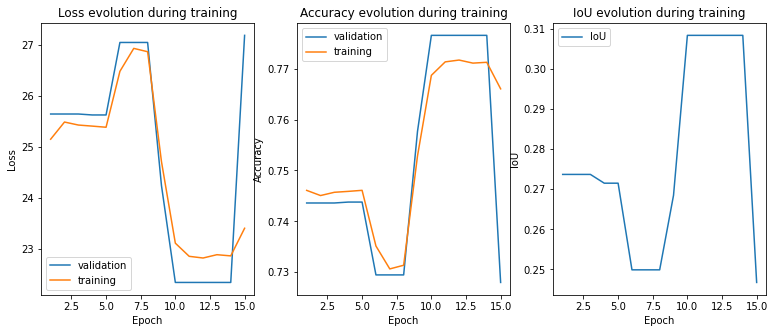

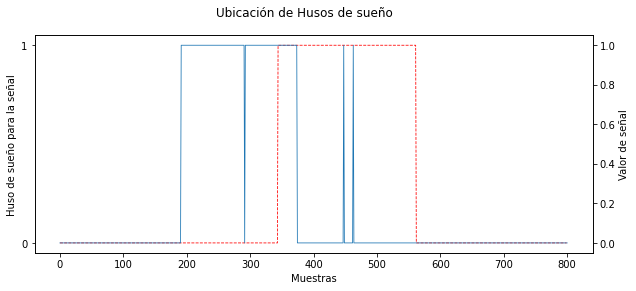

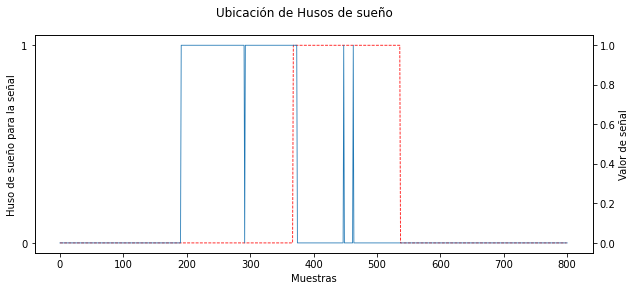

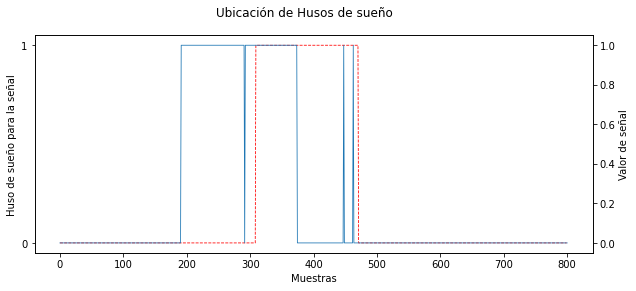

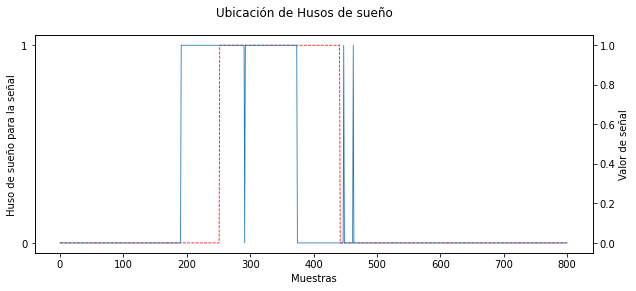

In [ ]:
class CNNModel5(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 70, kernel_size=128,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(70, 60, kernel_size=64,padding="same"),
            nn.ReLU(),

             # Bloque 2

            nn.Conv1d(60, 50, kernel_size=32,padding="same"),
            nn.ReLU(),

             # Bloque 2

            nn.Conv1d(50, 40, kernel_size=16,padding="same"),
            nn.ReLU(),

             # Bloque 2

            nn.Conv1d(40, 30, kernel_size=8,padding="same"),
            nn.ReLU(),

             # Bloque 2

            nn.Conv1d(30, 20, kernel_size=4,padding="same"),
            nn.ReLU(),

             # Bloque 2

            nn.Conv1d(20, 1, kernel_size=2,padding="same"),
            nn.ReLU(),
          

         
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,100),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(100,500),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(500,800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)



lr = 0.01
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel5(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

# **Aumentaremos la profundidad de los bloques**





Epoch 1/15


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Iteration 5 - Batch 5/298 - Train loss: 0.6929221153259277, Train acc: 0.5180555555555556
Iteration 10 - Batch 10/298 - Train loss: 0.692741025577892, Train acc: 0.5198333333333334
Iteration 15 - Batch 15/298 - Train loss: 0.692487183958292, Train acc: 0.5231197916666667
Iteration 20 - Batch 20/298 - Train loss: 0.6922676052365985, Train acc: 0.526218253968254
Iteration 25 - Batch 25/298 - Train loss: 0.6920624191944416, Train acc: 0.5290224358974359
Iteration 30 - Batch 30/298 - Train loss: 0.6918914741085421, Train acc: 0.5313064516129032
Iteration 35 - Batch 35/298 - Train loss: 0.6916724741458893, Train acc: 0.5342870370370371
Iteration 40 - Batch 40/298 - Train loss: 0.6914508371818356, Train acc: 0.5373963414634146
Iteration 45 - Batch 45/298 - Train loss: 0.6912353686664415, Train acc: 0.540518115942029
Iteration 50 - Batch 50/298 - Train loss: 0.691007073019065, Train acc: 0.5437091503267973
Iteration 55 - Batch 55/298 - Train loss: 0.6907862073608807, Train acc: 0.546916666666

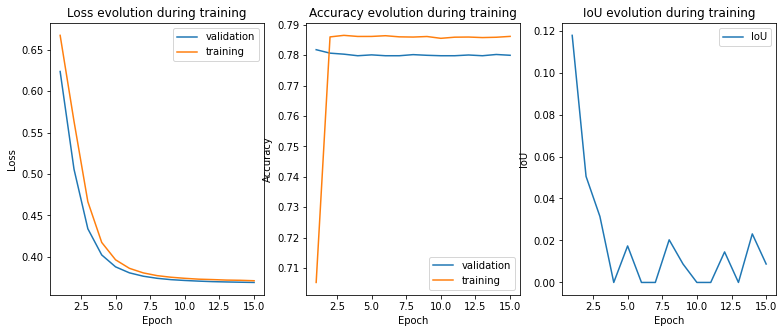

NameError: ignored

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 100, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(100, 50, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(50, 25,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(25, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)













lr = 0.0001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

**Variación de profundidad de bloques, pero ahora los haremos menos profundos**

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6928770442803701, Train acc: 0.5205555555555555
Iteration 10 - Batch 10/298 - Train loss: 0.6898946003480391, Train acc: 0.537280303030303
Iteration 15 - Batch 15/298 - Train loss: 0.6855113841593266, Train acc: 0.55371875
Iteration 20 - Batch 20/298 - Train loss: 0.6776934237707228, Train acc: 0.5697420634920635
Iteration 25 - Batch 25/298 - Train loss: 0.669518211713204, Train acc: 0.5846955128205128
Iteration 30 - Batch 30/298 - Train loss: 0.6615877113034648, Train acc: 0.5979408602150538
Iteration 35 - Batch 35/298 - Train loss: 0.6527154015170203, Train acc: 0.610224537037037
Iteration 40 - Batch 40/298 - Train loss: 0.6436545543554353, Train acc: 0.6211280487804878
Iteration 45 - Batch 45/298 - Train loss: 0.6333104449769725, Train acc: 0.6322119565217391
Iteration 50 - Batch 50/298 - Train loss: 0.6235363834044513, Train acc: 0.6426062091503268
Iteration 55 - Batch 55/298 - Train loss: 0.6132798945265157, Train acc: 0.6518779

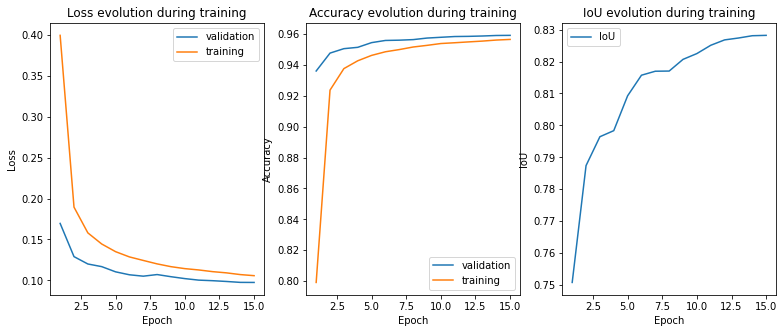

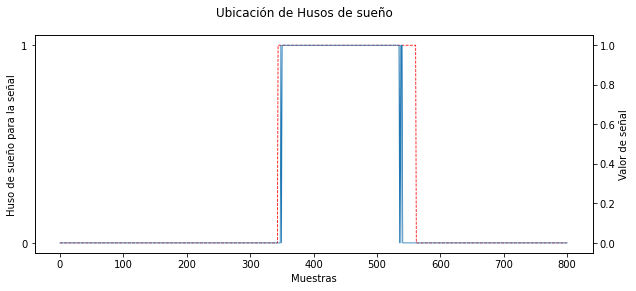

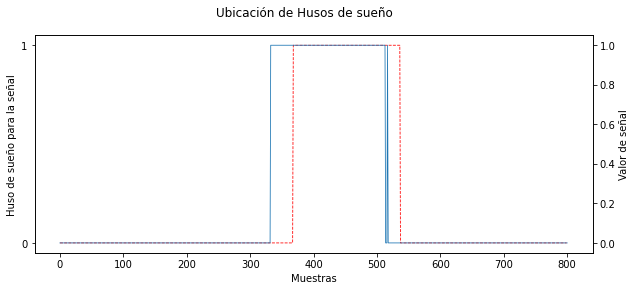

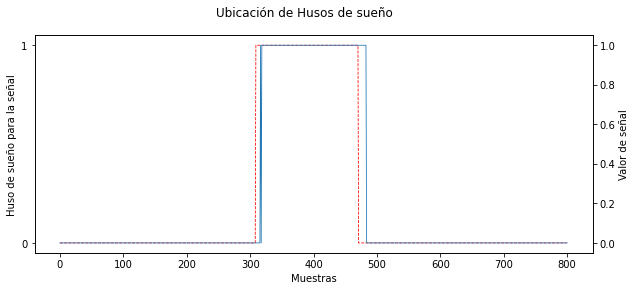

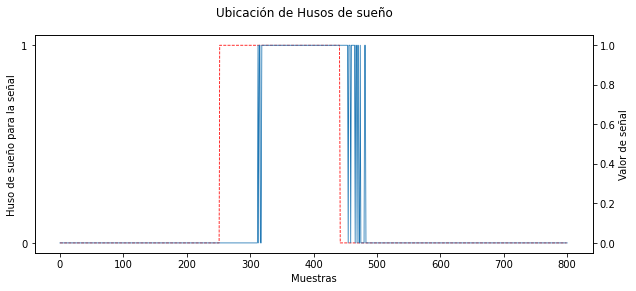

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 10, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(10, 5, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(5, 2,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(2, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)













lr = 0.0001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

Cambio de profundidad de bloques, ahora levemente un poco mas profundos

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6924775044123331, Train acc: 0.5183611111111112
Iteration 10 - Batch 10/298 - Train loss: 0.6909678361632607, Train acc: 0.5297727272727273
Iteration 15 - Batch 15/298 - Train loss: 0.6864956393837929, Train acc: 0.5458489583333334
Iteration 20 - Batch 20/298 - Train loss: 0.6788574144953773, Train acc: 0.5628055555555556
Iteration 25 - Batch 25/298 - Train loss: 0.6715772106097295, Train acc: 0.5789198717948718
Iteration 30 - Batch 30/298 - Train loss: 0.6623623755670363, Train acc: 0.5940430107526882
Iteration 35 - Batch 35/298 - Train loss: 0.651582173175282, Train acc: 0.6079930555555556
Iteration 40 - Batch 40/298 - Train loss: 0.6417455382463408, Train acc: 0.6206321138211383
Iteration 45 - Batch 45/298 - Train loss: 0.6313929337522258, Train acc: 0.6317391304347826
Iteration 50 - Batch 50/298 - Train loss: 0.6217397112472385, Train acc: 0.6418431372549019
Iteration 55 - Batch 55/298 - Train loss: 0.6126133549426284, Train acc:

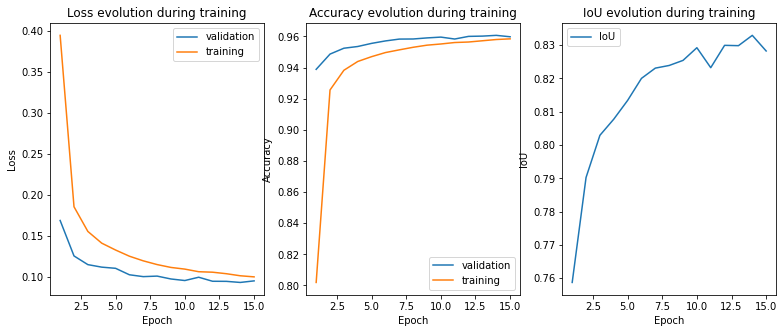

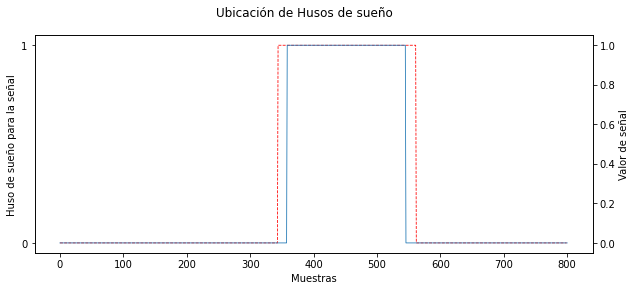

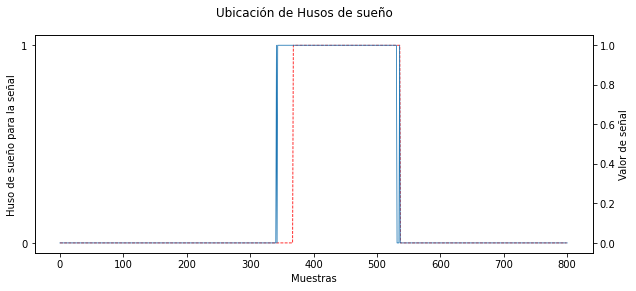

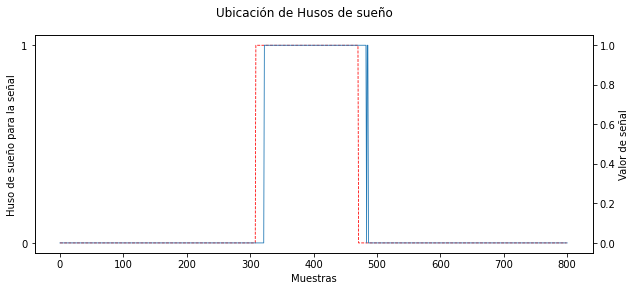

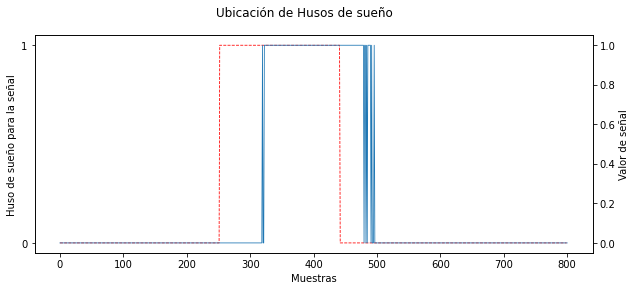

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 15, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(15, 10, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(10, 5,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(5, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)













lr = 0.0001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

Epoch 1/21
Iteration 5 - Batch 5/447 - Train loss: 0.6934263110160828, Train acc: 0.5045416666666667
Iteration 10 - Batch 10/447 - Train loss: 0.6932739127766002, Train acc: 0.505465909090909
Iteration 15 - Batch 15/447 - Train loss: 0.6932116970419884, Train acc: 0.5057109375
Iteration 20 - Batch 20/447 - Train loss: 0.6931498589969817, Train acc: 0.5062142857142857
Iteration 25 - Batch 25/447 - Train loss: 0.6931487734501178, Train acc: 0.5060432692307693
Iteration 30 - Batch 30/447 - Train loss: 0.6931099276388845, Train acc: 0.5067620967741936
Iteration 35 - Batch 35/447 - Train loss: 0.6930510782533221, Train acc: 0.50753125
Iteration 40 - Batch 40/447 - Train loss: 0.6930295548787931, Train acc: 0.5078445121951219
Iteration 45 - Batch 45/447 - Train loss: 0.6929529011249542, Train acc: 0.508625
Iteration 50 - Batch 50/447 - Train loss: 0.6928122990271625, Train acc: 0.510328431372549
Iteration 55 - Batch 55/447 - Train loss: 0.6926623891506877, Train acc: 0.5117678571428571
Itera

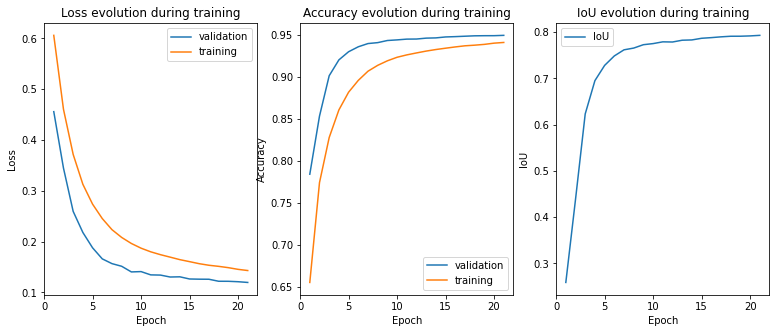

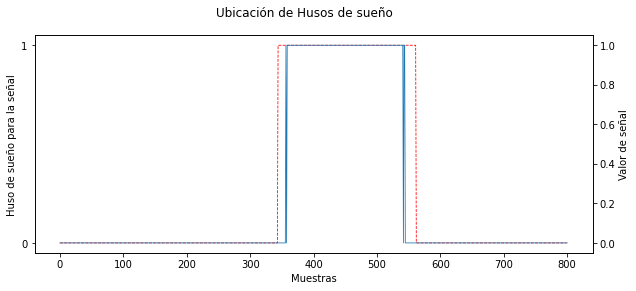

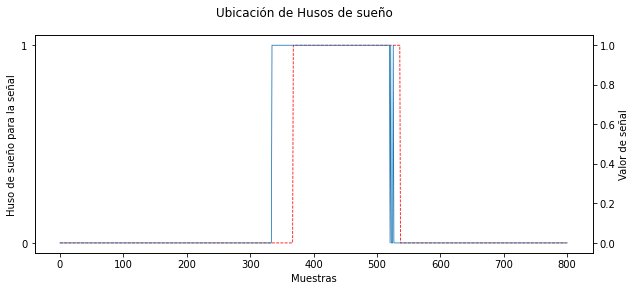

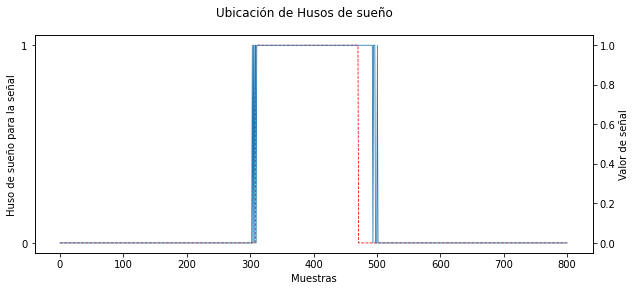

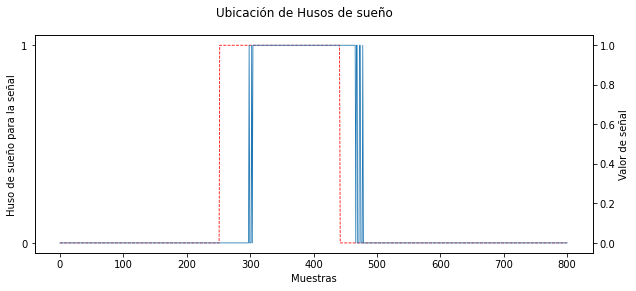

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 15, kernel_size=400,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(15, 10, kernel_size=200,padding="same"),
            nn.ReLU(),
          

            # Bloque 2

            nn.Conv1d(10, 10, kernel_size=100,padding="same"),
            nn.ReLU(),




            # Bloque 3

            nn.Conv1d(10, 5,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(5, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)













lr = 0.00001
dropout_p = 0.5
batch_size = 10
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 21
model = CNNModel2(dropout_p=0.5)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()